# Predicting Cassava Disease

#### Imports

In [69]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel, Dinov2Model
from torchvision import transforms
import time
import numpy as np
import pandas as pd
import json
import csv
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage import io, color, feature
from skimage.transform import resize
from skimage.feature import canny
from scipy.fft import fft2, fftshift
import multiprocessing
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [71]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### DinoV2 Feature Extraction

In [72]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up the model and image processor
model_name = "facebook/dinov2-large"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = Dinov2Model.from_pretrained(model_name)

# Set the device (GPU if available, otherwise CPU)
model.to(device)

Using device: cuda


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2SdpaAttention(
          (attention): Dinov2SdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
      

In [21]:
# Function to process a single image
def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the CLS token embedding (first token of the last hidden state)
    features = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()
    return os.path.basename(image_path), features

# Set the input folder and output CSV file
input_folder = "/content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images"
output_csv = "output_features.csv"

# Get all image files from the input folder
image_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder)
               if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# Process images in parallel and write features to CSV
with open(output_csv, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Write header
    header = ['image_name'] + [f'feature_{i}' for i in range(model.config.hidden_size)]
    csv_writer.writerow(header)

    # Use ThreadPoolExecutor for parallelism
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_image, image_file): image_file for image_file in image_files}

        for future in tqdm(futures, desc="Processing images"):
            try:
                image_name, features = future.result()
                # Write the image name and its features to the CSV
                row = [image_name] + list(features)
                csv_writer.writerow(row)
            except Exception as e:
                print(f"Error processing file {futures[future]}: {e}")

print(f"Features extracted and saved to {output_csv}")

Processing images: 100%|██████████| 17938/17938 [17:11<00:00, 17.38it/s]

Features extracted and saved to output_features.csv


In [61]:
_dino_feats_df = pd.read_csv('output_features.csv')
_dino_feats_df

image_name  feature_0  feature_1  feature_2  feature_3  feature_4  \
0       822187943.jpg  -1.048666  -0.923049  -1.202865  -0.196357  -0.841454   
1       832729024.jpg  -0.180360  -1.164006  -1.444271  -1.118975   2.749748   
2       828740814.jpg   0.705351  -2.085520  -0.874357   0.764680   2.821573   
3       812733394.jpg  -1.797357   0.747192  -1.194027  -0.312252   1.349946   
4       804506814.jpg  -1.252455  -1.067494  -1.311061   0.581473   2.030974   
...               ...        ...        ...        ...        ...        ...   
17933  1775105594.jpg  -0.749773  -1.646605  -0.989483   1.350407   3.589592   
17934  1765114818.jpg  -0.408830  -1.066255  -0.657110   0.678735   1.464073   
17935  1786164172.jpg   0.323535  -1.426993  -1.291440   0.031257   2.160862   
17936  1772421330.jpg  -0.694990  -1.899503  -2.620450   0.412444   2.696030   
17937  1775343418.jpg  -2.300794   0.632732  -0.254828  -1.646330   0.690680   

       feature_5  feature_6  feature_7  feature_8  ...  feature_1014  \
0      -0.168095  -1.669445   1.820414   1.066296  ...     -1.605657   
1       0.164371  -2.843348  -0.001607   0.540362  ...     -0.661446   
2      -1.348784  -2.234716  -1.117117   1.540342  ...     -1.755440   
3      -0.743088  -0.510547  -0.425993   0.226020  ...     -0.270525   
4      -2.172955  -1.581077   0.748563  -0.503183  ...      0.653943   
...          ...        ...        ...        ...  ...           ...   
17933  -1.250468  -1.095022  -0.207241   0.999513  ...     -0.361496   
17934  -0.970098  -1.516012   0.605625   0.570986  ...      0.241022   
17935  -0.346035  -2.156209  -0.159149   0.551207  ...     -0.552018   
17936   0.956773  -3.145855   0.644987   1.668708  ...     -0.389529   
17937   0.443608  -0.324070   0.119726   0.089521  ...     -1.878747   

       feature_1015  feature_1016  feature_1017  feature_1018  feature_1019  \
0          0.515200     -2.119276      0.184488      1.026151      1.069479   
1          1.835902      1.363414      0.761779     -2.121475     -0.602258   
2          2.285567      0.126892      0.024661     -2.062110      2.077015   
3          1.033668      0.402377      0.939856     -0.667014      2.101954   
4          2.220277      0.676021     -0.768719     -0.517700      1.210862   
...             ...           ...           ...           ...           ...   
17933      0.466057      0.280578      0.014967     -1.270621     -0.556336   
17934      1.176971      0.857893      2.684926     -1.208867      1.925698   
17935      0.994884      0.052513      0.331229     -1.192366      2.745815   
17936      1.963412     -0.780429      0.967421     -1.097904      3.791079   
17937      1.465508      1.066789      0.299729     -0.808397      1.106650   

       feature_1020  feature_1021  feature_1022  feature_1023  
0          1.028247     -1.764536      0.617378      2.925799  
1          0.029701     -1.909669     -0.059050      1.988316  
2          0.940626     -1.984525      0.612507      2.838747  
3         -1.364544     -1.843020     -0.809538      2.516396  
4          0.183417     -1.126209      2.455725      2.316100  
...             ...           ...           ...           ...  
17933      0.470843     -2.253881      0.953991      3.836546  
17934      0.971105     -3.114258      1.593496      2.089476  
17935      0.347218     -2.479473      0.775454      2.900737  
17936     -0.459222     -2.327107      0.375558      2.028278  
17937     -1.420310     -0.103591     -0.089464      1.741379  

[17938 rows x 1025 columns]

### Load Pre-computed DinoV2 Features - Optional

In [258]:
#path_to_dino_features = "/content/drive/MyDrive/DATASCI 281 Final Project/Data/dino_features.csv"
#_dino_feats_df = pd.read_csv(path_to_dino_features)
#_dino_feats_df

In [63]:
# DinoV2 Sanity Check
df1 = _dino_feats_df.copy()
df2 = recomputed_dino_feats_df.copy()

# Sort by 'image_name' and reset indices
df1_sorted = df1.sort_values(by="image_name").reset_index(drop=True)
df2_sorted = df2.sort_values(by="image_name").reset_index(drop=True)

# Check equality
are_equal = df1_sorted.equals(df2_sorted)

print("Are the DataFrames exactly equal?", are_equal)

# Ensure column alignment
if df1_sorted.columns.tolist() == df2_sorted.columns.tolist():
    # Check approximate equality
    numeric_cols = df1_sorted.select_dtypes(include=[np.number]).columns
    non_numeric_cols = [col for col in df1_sorted.columns if col not in numeric_cols]

    # Compare non-numeric columns for exact equality
    non_numeric_equal = df1_sorted[non_numeric_cols].equals(df2_sorted[non_numeric_cols])

    # Compare numeric columns for approximate equality
    numeric_equal = all(
        np.allclose(df1_sorted[col], df2_sorted[col], atol=1e-2, rtol=1e-5)
        for col in numeric_cols
    )

    # Final result
    are_approximately_equal = non_numeric_equal and numeric_equal
else:
    are_approximately_equal = False

print("Are the DataFrames approximately equal?", are_approximately_equal)

Are the DataFrames exactly equal? False
Are the DataFrames approximately equal? True


### Compute Additional Features - HOG, Color, Edge, Fourier

#### Pre-defined functions

In [54]:
# Load existing DINOv2 features
existing_features = _dino_feats_df.copy()  # Assuming this dataframe is already defined
image_folder = "/content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images"
json_file_path = '/content/drive/MyDrive/DATASCI 281 Final Project/Data/label_num_to_disease_map.json'
existing_images_path = '/content/drive/MyDrive/DATASCI 281 Final Project/Data/existing_images.csv'

# Load label map from JSON file
with open(json_file_path, 'r') as json_file:
    label_map = json.load(json_file)

existing_images_df = pd.read_csv(existing_images_path)

existing_features= existing_features.merge(right=existing_images_df,
                                           how='left',
                                           left_on=['image_name'],
                                           right_on=['image_id'])

# Adding disease labels to DINOv2 features dataset
existing_features['disease_name'] = existing_features['label'].astype(str).map(label_map)

# Copy to balanced_images
balanced_images = existing_features.copy()

def process_image(image_name, image_folder):
    try:
        # Load and resize image
        image_path = f"{image_folder}/{image_name}"
        image = io.imread(image_path)
        print(f'Processing image: {image_name}\n')
        gray_image = color.rgb2gray(image)
        gray_image_resized = resize(gray_image, (224, 224), anti_aliasing=True)

        # Compute HOG features
        hog_feature = feature.hog(
            gray_image_resized,
            orientations=6,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            feature_vector=True
        )

        # Compute color histogram features
        color_hist_feature = np.histogram(image, bins=32, range=(0, 256), density=True)[0]

        # Color-based features: mean and std of RGB channels
        mean_rgb = np.mean(image, axis=(0, 1))  # Mean of R, G, B
        std_rgb = np.std(image, axis=(0, 1))    # Standard deviation of R, G, B

        # Canny edge feature
        canny_edges = canny(gray_image_resized)
        edge_density = np.sum(canny_edges) / canny_edges.size  # Proportion of edges in the image

        # Fourier Transform feature (magnitude spectrum)
        image_fft = fft2(gray_image_resized)
        image_fft_shifted = fftshift(image_fft)  # Shift zero frequency to the center
        magnitude_spectrum = np.abs(image_fft_shifted)
        fft_mean = np.mean(magnitude_spectrum)
        fft_std = np.std(magnitude_spectrum)

        #print(f'Image processed: {image_path}')

        # Return computed features
        return (hog_feature, color_hist_feature, mean_rgb, std_rgb, edge_density, fft_mean, fft_std)

    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        return None

if __name__ == "__main__":
    # Set the start method for multiprocessing (for Colab compatibility)
    multiprocessing.set_start_method("fork", force=True)

    # Parallel processing using Pool
    with Pool(multiprocessing.cpu_count()) as pool:
        results = pool.starmap(process_image, [(image_name, image_folder) for image_name in balanced_images['image_name']])

    # Filter out None results
    valid_results = [r for r in results if r is not None]

    if valid_results:  # Ensure there are valid results
        # Unzip features into individual lists
        hog_features, color_hist_features, mean_rgb, std_rgb, edge_density, fft_mean, fft_std = zip(*valid_results)

        # Convert features to DataFrames
        hog_df = pd.DataFrame(hog_features, columns=[f'hog_{i}' for i in range(len(hog_features[0]))])
        color_hist_df = pd.DataFrame(color_hist_features, columns=[f'color_hist_{i}' for i in range(len(color_hist_features[0]))])

        # Additional feature DataFrames
        color_mean_df = pd.DataFrame(mean_rgb, columns=['mean_r', 'mean_g', 'mean_b'])
        color_std_df = pd.DataFrame(std_rgb, columns=['std_r', 'std_g', 'std_b'])
        edge_density_df = pd.DataFrame(edge_density, columns=['edge_density'])
        fft_mean_df = pd.DataFrame(fft_mean, columns=['fft_mean'])
        fft_std_df = pd.DataFrame(fft_std, columns=['fft_std'])

        # Concatenate all features with the original dataset
        balanced_images.reset_index(drop=True, inplace=True)
        combined_features = pd.concat([
            balanced_images,
            hog_df,
            color_hist_df,
            color_mean_df,
            color_std_df,
            edge_density_df,
            fft_mean_df,
            fft_std_df
        ], axis=1)

        # Save the processed dataset to a CSV file
        output_csv_path = "/content/combined_features_balanced.csv"
        combined_features.to_csv(output_csv_path, index=False)
        print(f"Saved combined features to {output_csv_path}")
    else:
        print("No valid results to process.")

Streaming output truncated to the last 5000 lines.

Processing image: 1884580980.jpg

Processing image: 1993626674.jpg

Processing image: 1656709823.jpg

Processing image: 1722126168.jpg

Processing image: 2121641395.jpg

Processing image: 191783616.jpg

Processing image: 2041164461.jpg
Processing image: 1841364017.jpg


Processing image: 2198912215.jpg

Processing image: 241455389.jpg

Processing image: 2154886042.jpg

Processing image: 1898762161.jpg

Processing image: 2260460957.jpg

Processing image: 1648944957.jpg

Processing image: 1754366174.jpg

Processing image: 2038601042.jpg
Processing image: 2139909622.jpg


Processing image: 1986081806.jpg

Processing image: 1823192027.jpg

Processing image: 1948698978.jpg
Processing image: 2237962396.jpg


Processing image: 2429254958.jpg

Processing image: 1893520640.jpg
Processing image: 2114639709.jpg
Processing image: 2254446708.jpg



Processing image: 1760495628.jpg
Processing image: 1654830882.jpg

Processing image: 2030983872.jpg


In [60]:
files.download("/content/combined_features_balanced.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
combined_features = pd.read_csv('combined_features_balanced.csv')

In [75]:
# Check for label column (e.g., 'disease_name')
if 'disease_name' in combined_features.columns:
    # Count the number of images per label
    label_counts = combined_features['disease_name'].value_counts()
    print("Number of images per label:\n", label_counts)

Number of images per label:
 disease_name
Cassava Mosaic Disease (CMD)           11027
Healthy                                 2166
Cassava Green Mottle (CGM)              1993
Cassava Brown Streak Disease (CBSD)     1831
Cassava Bacterial Blight (CBB)           921
Name: count, dtype: int64


In [76]:
# display the shape of the data
print(f"Number of rows: {combined_features.shape[0]}, Number of columns: {combined_features.shape[1]}")

Number of rows: 17938, Number of columns: 5125


### Dimentionality Reduction Using Principle Component Analysis

In [272]:
data = combined_features.copy()

feature_data = data.drop(columns=['image_name',
                                  'image_id',
                                  'label',
                                  'disease_name'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_data)

# Fit PCA to the data
pca = PCA()
pca.fit(feature_data)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for 95% variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {num_components}")

Number of components for 95% variance: 130


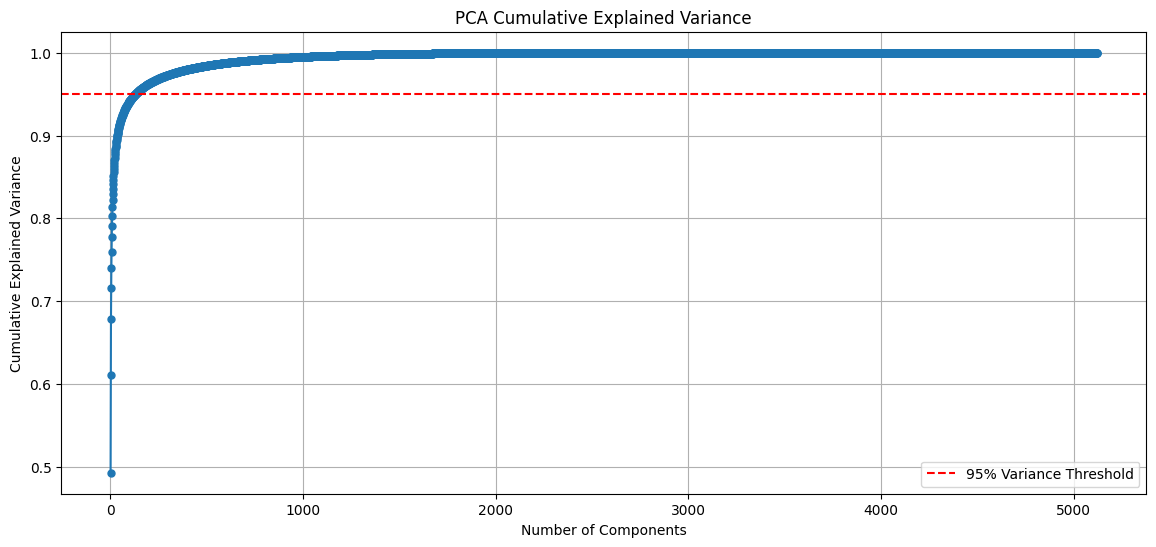

In [271]:
# Plot cumulative explained variance
plt.figure(figsize=(14, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', markersize=5)
plt.title('PCA Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# Exclude the 'image_name' , 'disease_name' column and standardize features
feature_data = data.drop(columns=['image_name',
                                  'image_id',
                                  'label',
                                  'disease_name'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_data)

# Apply PCA
pca = PCA(n_components=num_components)
pca_features = pca.fit_transform(scaled_features)

# Save PCA-transformed features
pca_features_df = pd.DataFrame(pca_features, columns=[f'pca_{i}' for i in range(pca.n_components_)])
pca_features_df['image_name'] = data['image_name']
pca_features_df['disease_name'] = data['disease_name']
pca_features_df['image_id'] = data['image_id']
pca_features_df['label'] = data['label']
pca_features_df.to_csv("pca_features_balanced.csv", index=False)
files.download("/content/pca_features_balanced.csv")
print("PCA features saved to 'pca_features_balanced.csv'")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PCA features saved to 'pca_features_balanced.csv'


In [79]:
print(f"Number of rows: {pca_features_df.shape[0]}, Number of columns: {pca_features_df.shape[1]}")

Number of rows: 17938, Number of columns: 134


In [149]:
data['disease_name'].value_counts()

disease_name
Cassava Mosaic Disease (CMD)           11027
Healthy                                 2166
Cassava Green Mottle (CGM)              1993
Cassava Brown Streak Disease (CBSD)     1831
Cassava Bacterial Blight (CBB)           921
Name: count, dtype: int64

In [150]:
pca_features_df['disease_name'].value_counts()

disease_name
Cassava Mosaic Disease (CMD)           11027
Healthy                                 2166
Cassava Green Mottle (CGM)              1993
Cassava Brown Streak Disease (CBSD)     1831
Cassava Bacterial Blight (CBB)           921
Name: count, dtype: int64

### Model Training

#### Define Validation Set

In [201]:
X = data.drop(
    columns=['image_name', 'image_id', 'label', 'disease_name'])
y = data['disease_name']

X, X_validation, y, y_validation = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)
print('Full dataset:')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X validation shape: {X_validation.shape}')
print(f'y validation shape: {y_validation.shape}')
print(np.unique(y_validation, return_counts=True))
print('')

pca_X = pca_features_df.drop(
    columns=['image_name', 'image_id', 'label', 'disease_name'])
pca_y = pca_features_df['disease_name']

pca_X, pca_X_validation, pca_y, pca_y_validation = train_test_split(pca_X, pca_y,
                                                    test_size=0.2,
                                                    stratify=pca_y,
                                                    random_state=42)

print('Reduced dimensionality dataset:')
print(f'X shape: {pca_X.shape}')
print(f'y shape: {pca_y.shape}')
print(f'X validation shape: {pca_X_validation.shape}')
print(f'y validation shape: {pca_y_validation.shape}')
print(np.unique(pca_y_validation, return_counts=True))

Full dataset:
X shape: (14350, 5121)
y shape: (14350,)
X validation shape: (3588, 5121)
y validation shape: (3588,)
(array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object), array([ 184,  366,  399, 2206,  433]))

Reduced dimensionality dataset:
X shape: (14350, 130)
y shape: (14350,)
X validation shape: (3588, 130)
y validation shape: (3588,)
(array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object), array([ 184,  366,  399, 2206,  433]))


#### Pre-defined functions

In [83]:
def get_balanced_train_test_split(X, y):
  # Step 1: Identify the smallest class
  class_counts = y.value_counts()
  min_class_size = class_counts.min()

  # Step 2: Downsample each class to match the smallest class size
  balanced_X = []
  balanced_y = []

  for class_label in class_counts.index:
      class_X = X[y == class_label]
      class_y = y[y == class_label]

      # Randomly sample to match the size of the smallest class
      sampled_class_X = class_X.sample(n=min_class_size, random_state=42)
      sampled_class_y = class_y.sample(n=min_class_size, random_state=42)

      balanced_X.append(sampled_class_X)
      balanced_y.append(sampled_class_y)

  # Step 3: Concatenate the balanced data back together
  balanced_X = pd.concat(balanced_X, axis=0)
  balanced_y = pd.concat(balanced_y, axis=0)

  # Step 4: Split into train and test sets with stratification
  X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y,
                                                      test_size=0.2,
                                                      stratify=balanced_y,
                                                      random_state=42)

  print(np.unique(balanced_y, return_counts=True))

  return X_train, X_test, y_train, y_test

In [84]:
def train_rf(X_train, y_train, X_test, y_test):

  # Define the objective function for Bayesian optimization
  def objective(params):
      # Create the Random Forest model with parameters
      clf = RandomForestClassifier(
          n_estimators=int(params["n_estimators"]),
          max_depth=int(params["max_depth"]),
          min_samples_split=int(params["min_samples_split"]),
          min_samples_leaf=int(params["min_samples_leaf"]),
          max_features=params["max_features"],
          class_weight='balanced',
          random_state=42,
      )
      # Train the model
      clf.fit(X_train, y_train)

      # Evaluate the model on the test set
      y_pred = clf.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)

      # Minimize -accuracy (hyperopt minimizes the objective function)
      return {"loss": -accuracy, "status": STATUS_OK}

  # Define the search space
  space = {
      "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
      "max_depth": hp.quniform("max_depth", 5, 30, 1),
      "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1),
      "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 5, 1),
      "max_features": hp.choice("max_features", ["sqrt"]),
  }

  # Run Bayesian optimization
  trials = Trials()
  best_params = fmin(
      fn=objective,
      space=space,
      algo=tpe.suggest,
      max_evals=5,  # Number of iterations for optimization
      trials=trials,
      rstate=np.random.default_rng(42)  # Ensures reproducibility
  )

  # Best parameters
  print("Best Parameters:", best_params)

  # Train the final model with the best parameters
  final_clf = RandomForestClassifier(
      n_estimators=int(best_params["n_estimators"]),
      max_depth=int(best_params["max_depth"]),
      min_samples_split=int(best_params["min_samples_split"]),
      min_samples_leaf=int(best_params["min_samples_leaf"]),
      max_features=["sqrt"][best_params["max_features"]],
      class_weight='balanced',
      random_state=42,
  )
  final_clf.fit(X_train, y_train)

  # Evaluate the final model
  y_pred = final_clf.predict(X_test)
  print("Final Accuracy:", accuracy_score(y_test, y_pred))
  print("Classification Report:\n", classification_report(y_test, y_pred))
  return final_clf, y_pred

In [173]:
def train_xgboost(X_train, y_train, X_test, y_test):

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)

    # Define the objective function for Bayesian optimization
    def objective(params):
        # Create the XGBoost model with parameters
        clf = XGBClassifier(
            n_estimators=int(params["n_estimators"]),
            max_depth=int(params["max_depth"]),
            learning_rate=params["learning_rate"],
            gamma=params["gamma"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            random_state=42,
            eval_metric="logloss"  # Specify an evaluation metric
        )
        # Train the model
        clf.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Minimize -accuracy (hyperopt minimizes the objective function)
        return {"loss": -accuracy, "status": STATUS_OK}

    # Define the search space
    space = {
        "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
        "max_depth": hp.quniform("max_depth", 3, 15, 1),
        "learning_rate": hp.loguniform("learning_rate", -3, 0),  # Log scale for learning rates
        "gamma": hp.uniform("gamma", 0, 5),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    }

    # Run Bayesian optimization
    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=5,  # Number of iterations for optimization
        trials=trials,
        rstate=np.random.default_rng(42)  # Ensures reproducibility
    )

    # Best parameters
    print("Best Parameters:", best_params)

    # Train the final model with the best parameters
    final_clf = XGBClassifier(
        n_estimators=int(best_params["n_estimators"]),
        max_depth=int(best_params["max_depth"]),
        learning_rate=best_params["learning_rate"],
        gamma=best_params["gamma"],
        subsample=best_params["subsample"],
        colsample_bytree=best_params["colsample_bytree"],
        random_state=42,
        eval_metric="logloss"
    )
    final_clf.fit(X_train, y_train)

    # Evaluate the final model
    y_pred = final_clf.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred)
    print("Final Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return final_clf, y_pred

In [177]:
def get_feat_importances(clf, _X):
  feature_names = [f"feature {i}" for i in range(_X.shape[1])]
  importances = clf.feature_importances_
  return pd.DataFrame(
      pd.Series(importances,
                index=feature_names).sort_values(
                    ascending=False)).reset_index().rename(
                        columns={'index': 'feature', 0: 'contribution'})

In [87]:
def plot_confusion_matrix(y_test, y_pred):
  # Compute confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

In [88]:
def plot_roc_auc(clf, X_test, y_test):
  # Assuming 'model' is your trained model, and 'X_test' and 'y_test' are your test data and labels
  n_classes = len(set(y_test))  # Number of unique classes

  unique_classes = sorted(set(y_test))
  print("Unique classes:", unique_classes)

  # Binarize the true labels for multi-class classification
  y_test_bin = label_binarize(y_test, classes=unique_classes)  # Adjust class labels accordingly
  y_score = clf.predict_proba(X_test)  # Model predictions for each class

  # Initialize the plot
  plt.figure(figsize=(8, 6))

  # Iterate over each class to compute the ROC curve
  for i in range(n_classes):
      fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc = auc(fpr, tpr)  # Calculate AUC for this class
      plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

  # Plot the random classifier line (diagonal)
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

  # Set plot labels and title
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class (One-vs-Rest)')
  plt.legend(loc='lower right')

  # Show the plot
  plt.show()

  # Optional: Compute and print the macro-average AUC score
  roc_auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
  print(f'Macro-average AUC: {roc_auc_macro:.2f}')

In [176]:
def model_pipeline(_X, _y, clf_model_name, balanced):
  print('Beginning training...')
  print(f'Balanced train-test split: {balanced}')
  print(f'Model Algorithm: {clf_model_name}')

  if balanced:
    _X_train, _X_test, _y_train, _y_test = get_balanced_train_test_split(X=_X, y=_y)
  else:
    _X_train, _X_test, _y_train, _y_test = train_test_split(_X, _y,
                                                            test_size=0.2,
                                                            stratify=y,
                                                            random_state=42)

  print(f'X train shape: {_X_train.shape}')
  print(f'y train shape: {_y_train.shape}')
  print(f'X test shape: {_X_test.shape}')
  print(f'y test shape: {_y_test.shape}')

  if clf_model_name == 'rf':
    final_clf, y_pred = train_rf(X_train=_X_train,
                                 X_test=_X_test,
                                 y_train=_y_train,
                                 y_test=_y_test)

  if clf_model_name == 'xgb':
    final_clf, y_pred = train_xgboost(X_train=_X_train,
                                      X_test=_X_test,
                                      y_train=_y_train,
                                      y_test=_y_test)

  feature_importances = get_feat_importances(clf=final_clf, _X=_X)

  plot_confusion_matrix(y_pred=y_pred, y_test=_y_test)

  plot_roc_auc(clf=final_clf, X_test=_X_test, y_test=_y_test)

  return {'X_train': _X_train,
          'y_train': _y_train,
          'X_test': _X_test,
          'y_test': _y_test,
          'model': final_clf,
          'y_pred': y_pred,
          'feat_importances': feature_importances
          }

In [202]:
def run_validation_metrics(_model, _X_validation, _y_validation, y_train=None):

  validation_predictions = _model.predict(_X_validation)

  if y_train is not None:
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    validation_predictions = label_encoder.inverse_transform(validation_predictions)

  print("Validation Accuracy:",
        accuracy_score(_y_validation,  validation_predictions))

  print("Classification Report:\n",
        classification_report(_y_validation, validation_predictions))

  plot_confusion_matrix(y_test=_y_validation,
                        y_pred=validation_predictions)

  plot_roc_auc(clf=_model,
              X_test=_X_validation,
              y_test=validation_predictions)

  return {'accuracy':accuracy_score(_y_validation,
                                    validation_predictions),
          'classifcation_report': classification_report(_y_validation,
                                                        validation_predictions,
                                                        output_dict=True)
          }

#### Balanced Model

##### Train

Beginning training...
Balanced train-test split: True
Model Algorithm: rf
(array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object), array([737, 737, 737, 737, 737]))
X train shape: (2948, 5121)
y train shape: (2948,)
X test shape: (737, 5121)
y test shape: (737,)
100%|██████████| 5/5 [02:09<00:00, 25.94s/trial, best loss: -0.6268656716417911]
Best Parameters: {'max_depth': 14.0, 'max_features': 0, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 180.0}
Final Accuracy: 0.6268656716417911
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.53      0.70      0.60       148
Cassava Brown Streak Disease (CBSD)       0.63      0.46      0.53       147
         Cassava Green Mottle (CGM)       0.66      0.59      0.62       147
       Cassava Mosaic Di

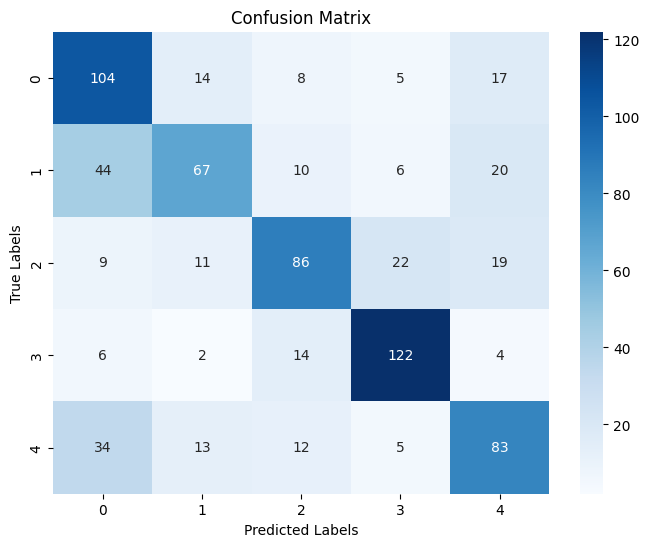

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


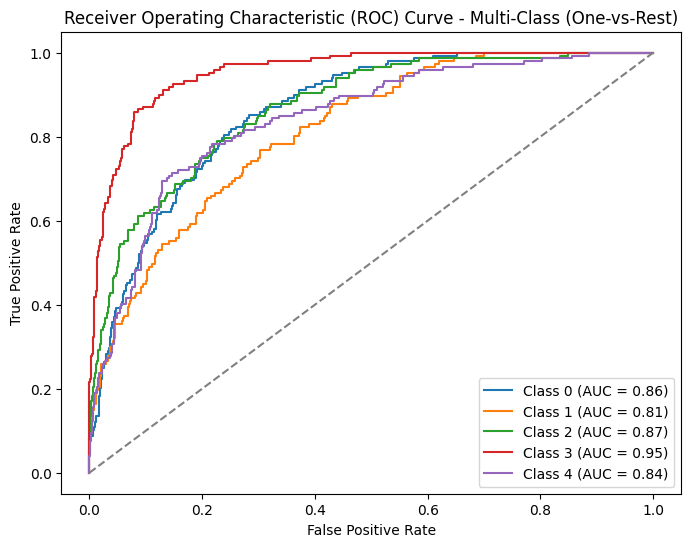

Macro-average AUC: 0.87


In [112]:
balanced_results_rf = model_pipeline(_X=X, _y=y, clf_model_name='rf', balanced=True)

Beginning training...
Balanced train-test split: True
Model Algorithm: xgb
(array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object), array([737, 737, 737, 737, 737]))
X train shape: (2948, 5121)
y train shape: (2948,)
X test shape: (737, 5121)
y test shape: (737,)
100%|██████████| 1/1 [00:54<00:00, 54.30s/trial, best loss: -0.0]
Best Parameters: {'colsample_bytree': 0.5568981335918035, 'gamma': 3.8392819888268797, 'learning_rate': 0.3517717325722587, 'max_depth': 14.0, 'n_estimators': 210.0, 'subsample': 0.9068277038201439}
Final Accuracy: 0.6594301221166893
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.62      0.70      0.66       148
Cassava Brown Streak Disease (CBSD)       0.62      0.57      0.60       147
         Cassava Green Mottle (CGM)       0.68

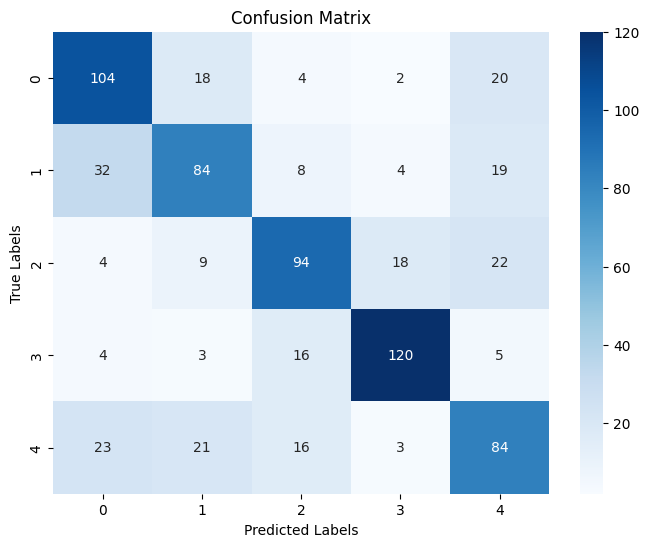

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


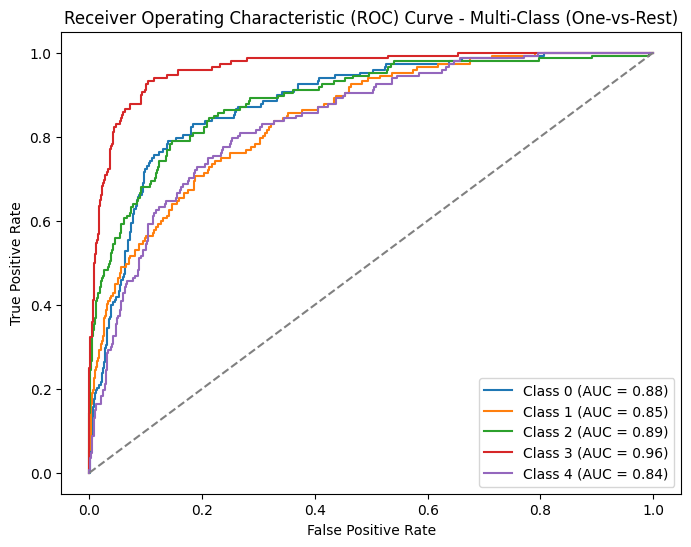

Macro-average AUC: 0.89


In [166]:
balanced_results_xgb = model_pipeline(_X=X, _y=y, clf_model_name='xgb', balanced=True)

##### Validate

Validation Accuracy: 0.7006688963210702
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.31      0.73      0.44       184
Cassava Brown Streak Disease (CBSD)       0.50      0.44      0.47       366
         Cassava Green Mottle (CGM)       0.46      0.63      0.53       399
       Cassava Mosaic Disease (CMD)       0.95      0.79      0.86      2206
                            Healthy       0.49      0.52      0.51       433

                           accuracy                           0.70      3588
                          macro avg       0.54      0.62      0.56      3588
                       weighted avg       0.76      0.70      0.72      3588



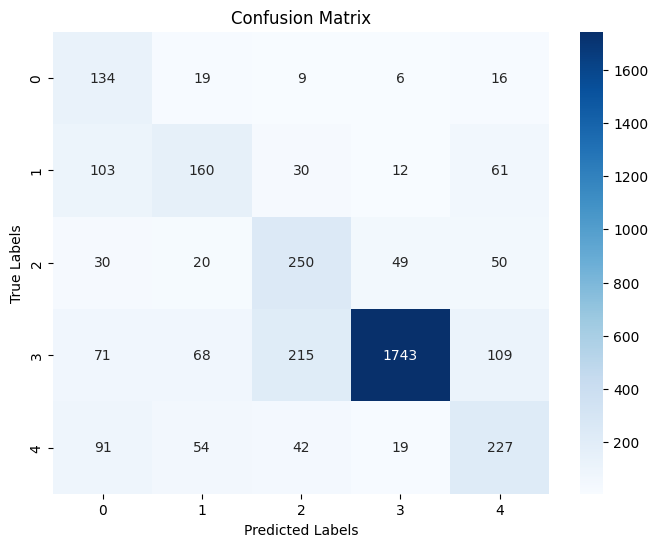

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


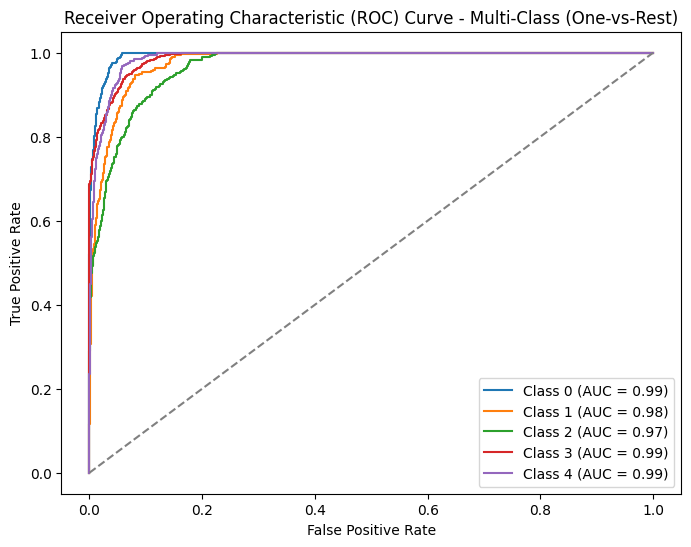

Macro-average AUC: 0.98


In [204]:
balanced_rf_validation_metrics = run_validation_metrics(
    _model=balanced_results_rf['model'],
    _X_validation=X_validation,
    _y_validation=y_validation)

Validation Accuracy: 0.705406911928651
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.34      0.68      0.45       184
Cassava Brown Streak Disease (CBSD)       0.52      0.51      0.51       366
         Cassava Green Mottle (CGM)       0.45      0.64      0.53       399
       Cassava Mosaic Disease (CMD)       0.96      0.78      0.86      2206
                            Healthy       0.49      0.57      0.53       433

                           accuracy                           0.71      3588
                          macro avg       0.55      0.64      0.58      3588
                       weighted avg       0.77      0.71      0.73      3588



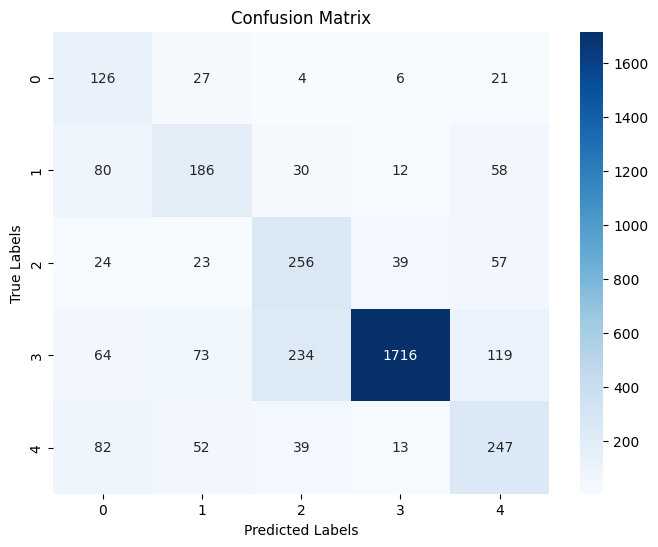

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


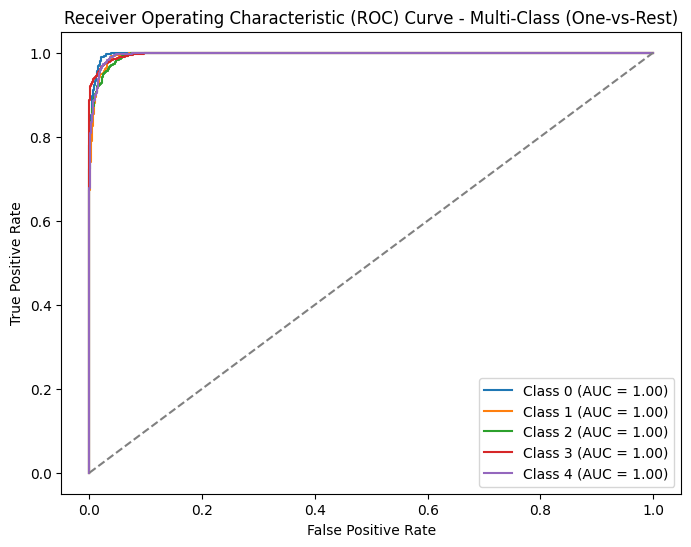

Macro-average AUC: 1.00


In [205]:
balanced_xgb_validation_metrics = run_validation_metrics(
    _model=balanced_results_xgb['model'],
    _X_validation=X_validation,
    _y_validation=y_validation,
    y_train=balanced_results_xgb['y_train'])

#### Unbalanced model

##### Train

Beginning training...
Balanced train-test split: False
Model Algorithm: rf
X train shape: (11480, 5121)
y train shape: (11480,)
X test shape: (2870, 5121)
y test shape: (2870,)
100%|██████████| 5/5 [10:52<00:00, 130.46s/trial, best loss: -0.7679442508710801]
Best Parameters: {'max_depth': 9.0, 'max_features': 0, 'min_samples_leaf': 3.0, 'min_samples_split': 3.0, 'n_estimators': 90.0}
Final Accuracy: 0.7679442508710801
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.45      0.47      0.46       147
Cassava Brown Streak Disease (CBSD)       0.54      0.57      0.55       293
         Cassava Green Mottle (CGM)       0.62      0.53      0.57       319
       Cassava Mosaic Disease (CMD)       0.91      0.89      0.90      1764
                            Healthy       0.55      0.65      0.60       347

                           accuracy                           0.77      2870
             

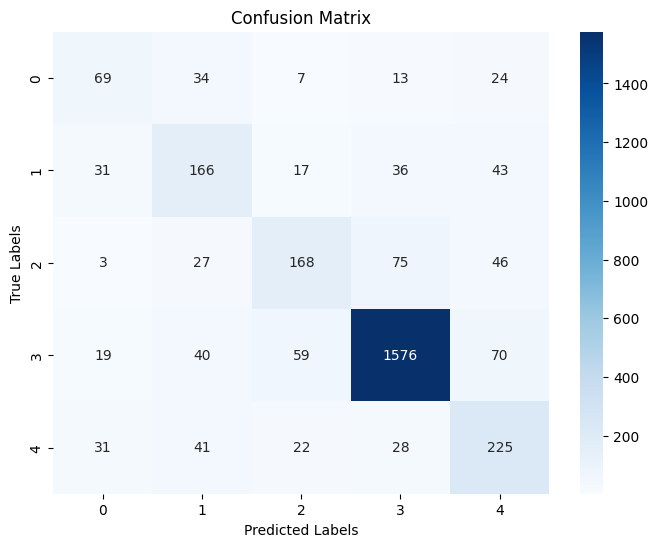

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


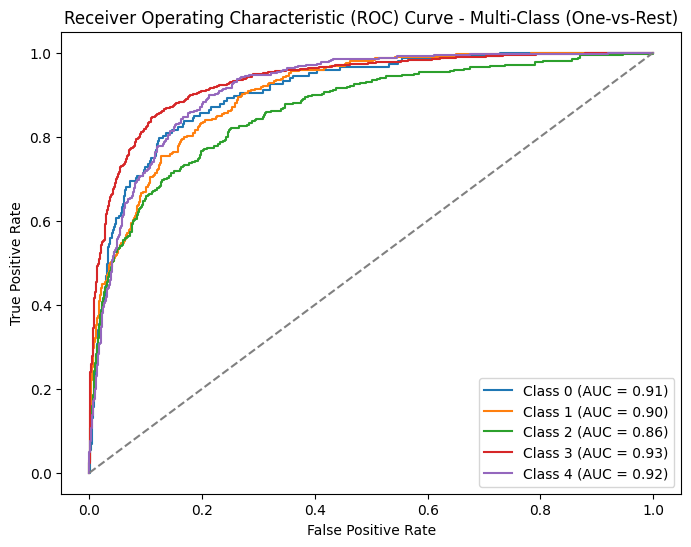

Macro-average AUC: 0.91


In [127]:
unbalanced_results_rf = model_pipeline(_X=X, _y=y, clf_model_name='rf', balanced=False)

Beginning training...
Balanced train-test split: False
Model Algorithm: xgb
X train shape: (11480, 5121)
y train shape: (11480,)
X test shape: (2870, 5121)
y test shape: (2870,)
100%|██████████| 5/5 [18:24<00:00, 220.91s/trial, best loss: -0.0]
Best Parameters: {'colsample_bytree': 0.5568981335918035, 'gamma': 3.8392819888268797, 'learning_rate': 0.3517717325722587, 'max_depth': 14.0, 'n_estimators': 210.0, 'subsample': 0.9068277038201439}
Final Accuracy: 0.8017421602787457
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.52      0.40      0.45       147
Cassava Brown Streak Disease (CBSD)       0.64      0.60      0.62       293
         Cassava Green Mottle (CGM)       0.72      0.53      0.61       319
       Cassava Mosaic Disease (CMD)       0.89      0.95      0.92      1764
                            Healthy       0.62      0.63      0.62       347

                           accura

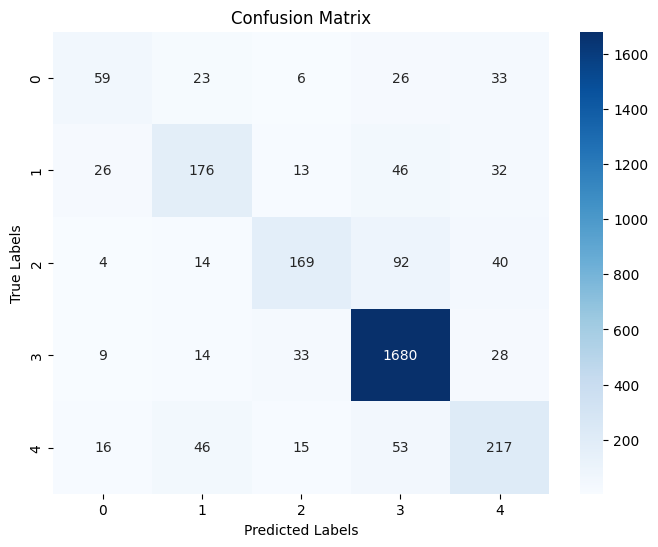

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


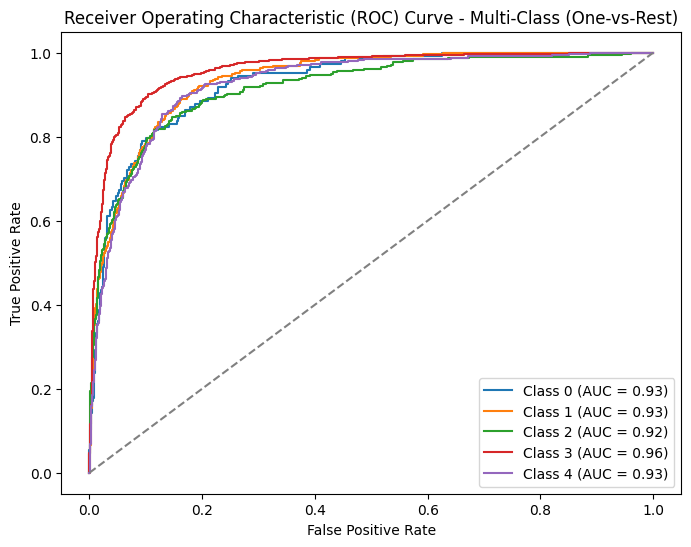

Macro-average AUC: 0.93


In [189]:
unbalanced_results_xgb = model_pipeline(_X=X, _y=y, clf_model_name='xgb', balanced=False)

##### Validate

Validation Accuracy: 0.770066889632107
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.44      0.52      0.48       184
Cassava Brown Streak Disease (CBSD)       0.56      0.53      0.54       366
         Cassava Green Mottle (CGM)       0.64      0.52      0.58       399
       Cassava Mosaic Disease (CMD)       0.91      0.91      0.91      2206
                            Healthy       0.52      0.59      0.55       433

                           accuracy                           0.77      3588
                          macro avg       0.61      0.61      0.61      3588
                       weighted avg       0.77      0.77      0.77      3588



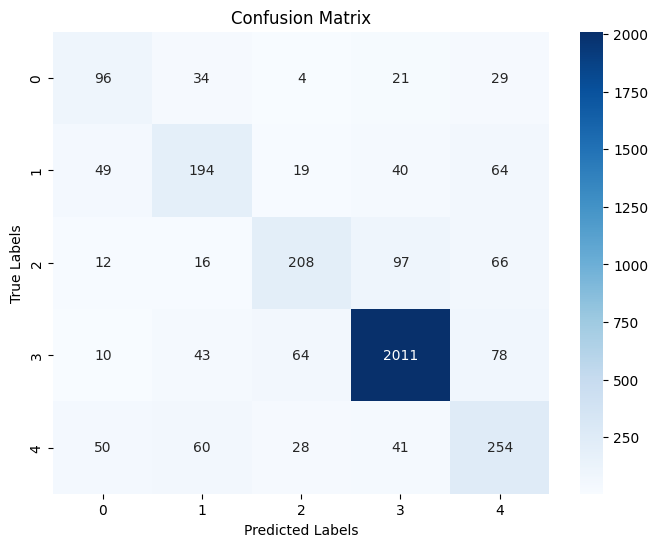

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


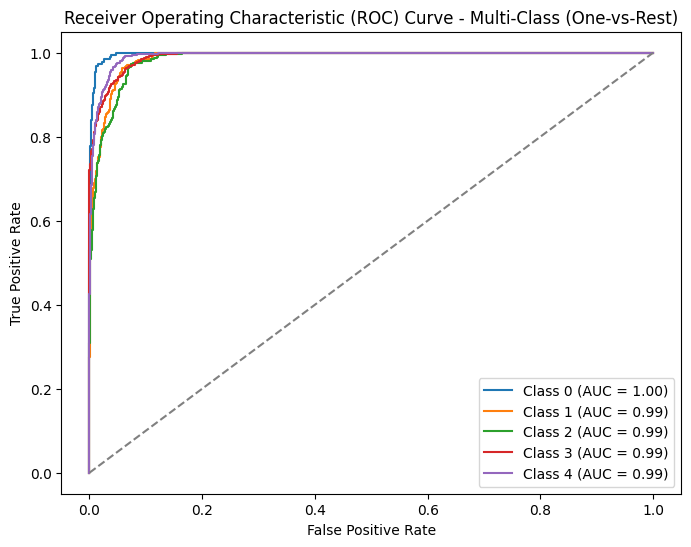

Macro-average AUC: 0.99


In [207]:
unbalanced_rf_validation_metrics = run_validation_metrics(
    _model=unbalanced_results_rf['model'],
    _X_validation=X_validation,
    _y_validation=y_validation)

Validation Accuracy: 0.8088071348940914
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.49      0.47      0.48       184
Cassava Brown Streak Disease (CBSD)       0.65      0.60      0.62       366
         Cassava Green Mottle (CGM)       0.73      0.53      0.62       399
       Cassava Mosaic Disease (CMD)       0.90      0.97      0.93      2206
                            Healthy       0.62      0.58      0.60       433

                           accuracy                           0.81      3588
                          macro avg       0.68      0.63      0.65      3588
                       weighted avg       0.80      0.81      0.80      3588



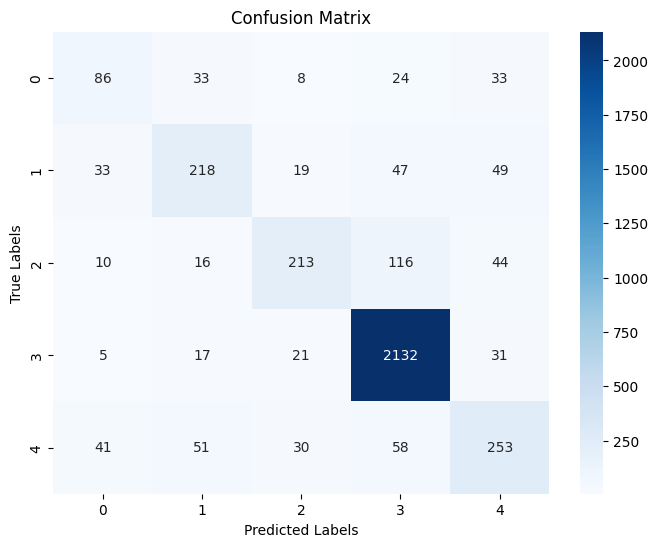

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


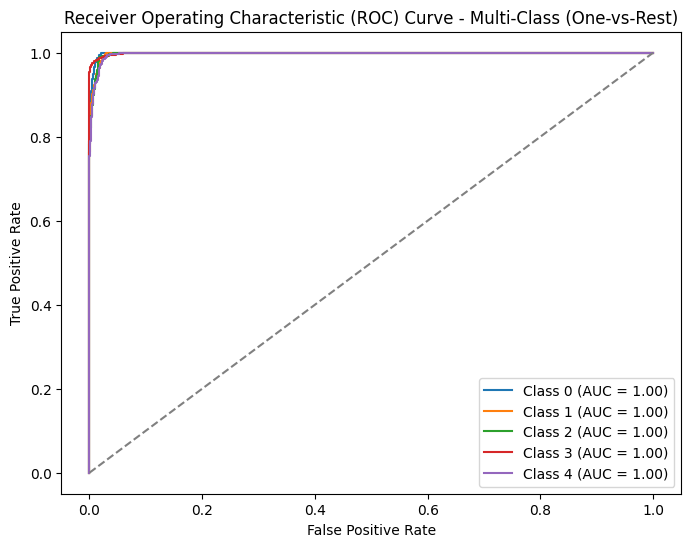

Macro-average AUC: 1.00


In [208]:
unbalanced_xgb_validation_metrics = run_validation_metrics(
    _model=unbalanced_results_xgb['model'],
    _X_validation=X_validation,
    _y_validation=y_validation,
    y_train=unbalanced_results_xgb['y_train'])

#### Reduced Dimensionality Balanced Model

##### Train

Beginning training...
Balanced train-test split: True
Model Algorithm: rf
(array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object), array([737, 737, 737, 737, 737]))
X train shape: (2948, 130)
y train shape: (2948,)
X test shape: (737, 130)
y test shape: (737,)
100%|██████████| 5/5 [00:22<00:00,  4.40s/trial, best loss: -0.5522388059701493]
Best Parameters: {'max_depth': 21.0, 'max_features': 0, 'min_samples_leaf': 5.0, 'min_samples_split': 7.0, 'n_estimators': 250.0}
Final Accuracy: 0.5522388059701493
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.47      0.61      0.53       148
Cassava Brown Streak Disease (CBSD)       0.56      0.38      0.45       147
         Cassava Green Mottle (CGM)       0.58      0.50      0.53       147
       Cassava Mosaic Dise

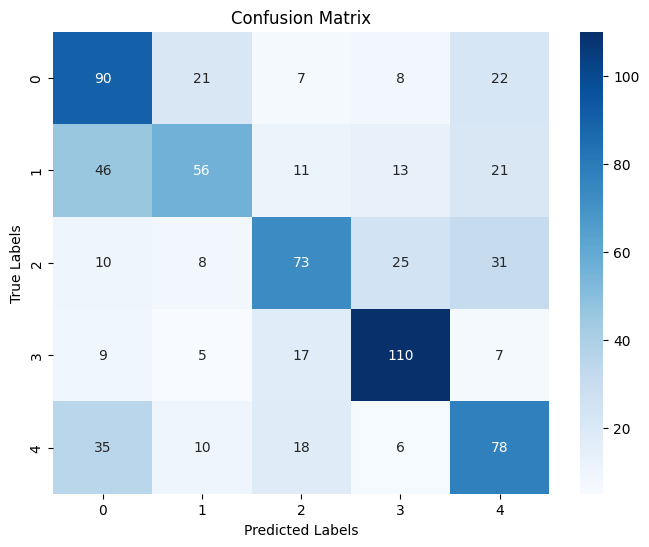

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


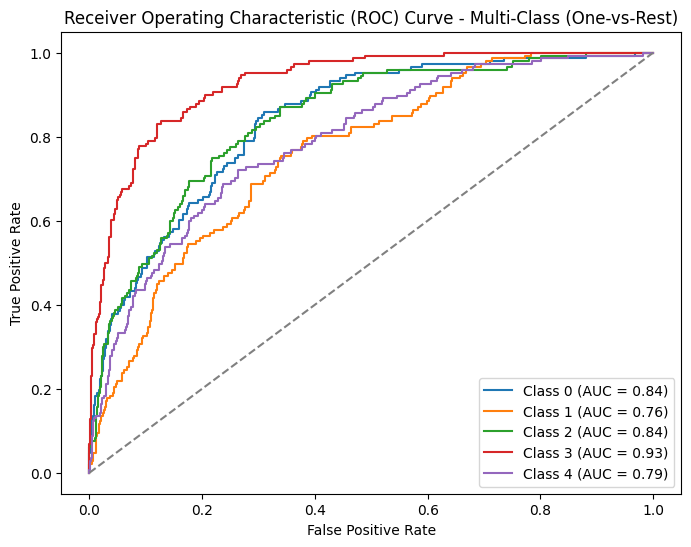

Macro-average AUC: 0.83


In [180]:
pca_balanced_results_rf = model_pipeline(_X=pca_X,
                                         _y=pca_y,
                                         clf_model_name='rf',
                                         balanced=True)

Beginning training...
Balanced train-test split: True
Model Algorithm: xgb
(array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object), array([737, 737, 737, 737, 737]))
X train shape: (2948, 130)
y train shape: (2948,)
X test shape: (737, 130)
y test shape: (737,)
100%|██████████| 5/5 [00:09<00:00,  1.90s/trial, best loss: -0.0]
Best Parameters: {'colsample_bytree': 0.5568981335918035, 'gamma': 3.8392819888268797, 'learning_rate': 0.3517717325722587, 'max_depth': 14.0, 'n_estimators': 210.0, 'subsample': 0.9068277038201439}
Final Accuracy: 0.5210312075983717
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.51      0.52      0.52       148
Cassava Brown Streak Disease (CBSD)       0.44      0.41      0.43       147
         Cassava Green Mottle (CGM)       0.54  

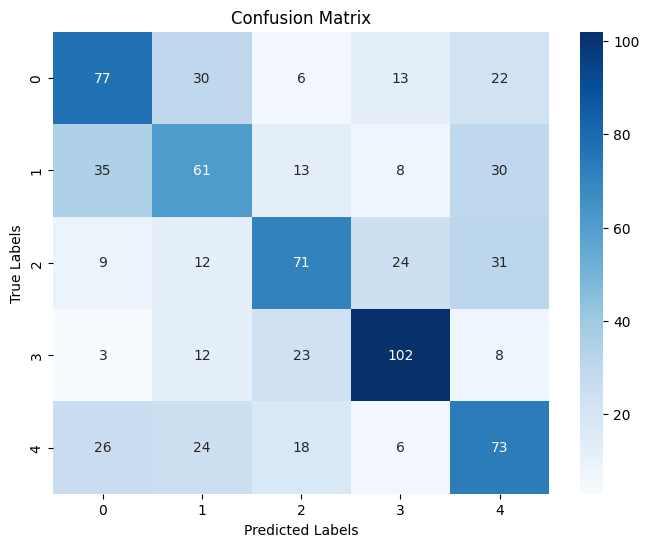

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


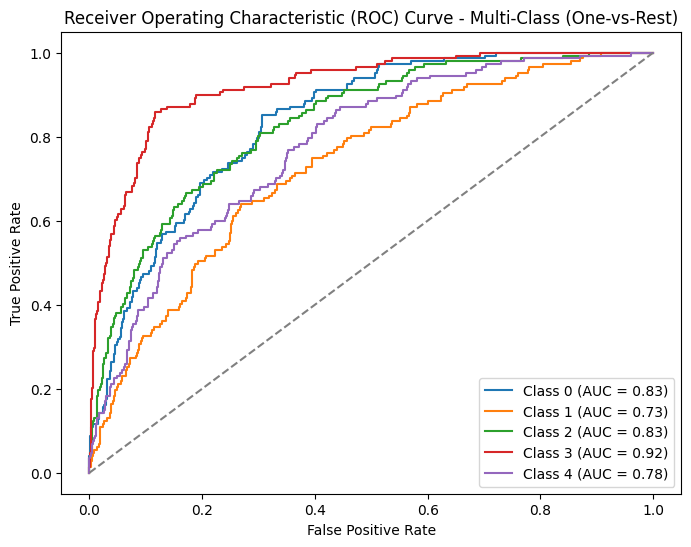

Macro-average AUC: 0.82


In [182]:
pca_balanced_results_xgb = model_pipeline(_X=pca_X, _y=pca_y, clf_model_name='xgb', balanced=True)

##### Validate

Validation Accuracy: 0.6215161649944259
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.26      0.64      0.37       184
Cassava Brown Streak Disease (CBSD)       0.37      0.33      0.35       366
         Cassava Green Mottle (CGM)       0.35      0.51      0.42       399
       Cassava Mosaic Disease (CMD)       0.93      0.71      0.81      2206
                            Healthy       0.39      0.50      0.44       433

                           accuracy                           0.62      3588
                          macro avg       0.46      0.54      0.48      3588
                       weighted avg       0.71      0.62      0.65      3588



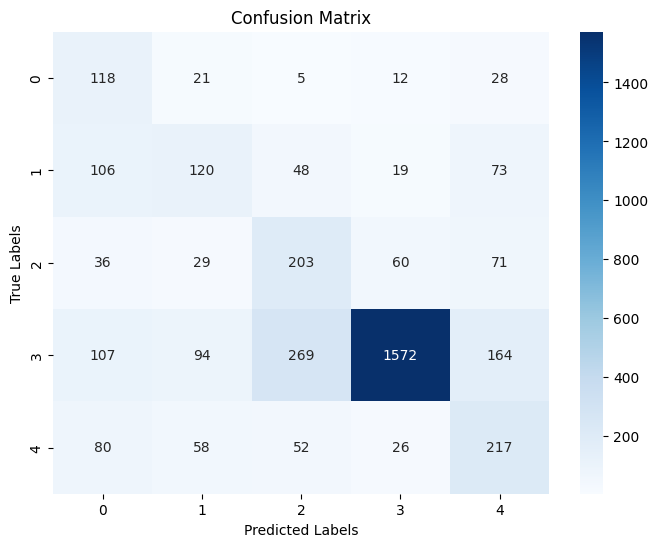

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


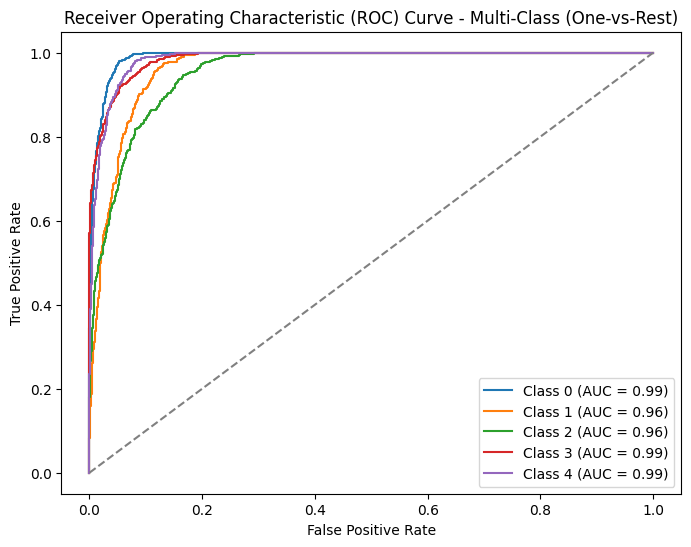

Macro-average AUC: 0.98


In [211]:
pca_balanced_rf_validation_metrics = run_validation_metrics(
    _model=pca_balanced_results_rf['model'],
    _X_validation=pca_X_validation,
    _y_validation=pca_y_validation)

Validation Accuracy: 0.5955964325529542
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.26      0.53      0.35       184
Cassava Brown Streak Disease (CBSD)       0.33      0.42      0.37       366
         Cassava Green Mottle (CGM)       0.31      0.51      0.38       399
       Cassava Mosaic Disease (CMD)       0.94      0.67      0.78      2206
                            Healthy       0.40      0.46      0.43       433

                           accuracy                           0.60      3588
                          macro avg       0.45      0.52      0.46      3588
                       weighted avg       0.70      0.60      0.63      3588



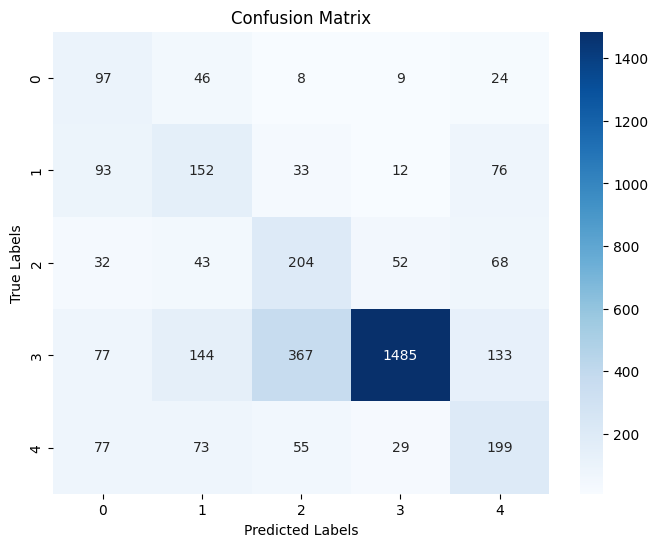

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


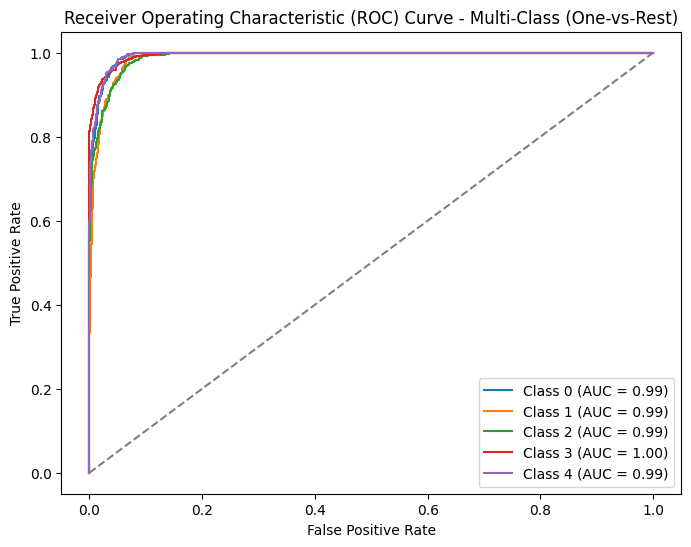

Macro-average AUC: 0.99


In [213]:
pca_balanced_xgb_validation_metrics = run_validation_metrics(
    _model=pca_balanced_results_xgb['model'],
    _X_validation=pca_X_validation,
    _y_validation=pca_y_validation,
    y_train=pca_balanced_results_xgb['y_train'])

#### Reduced Dimensionality Unbalanced Model

##### Train

Beginning training...
Balanced train-test split: False
Model Algorithm: rf
X train shape: (11480, 130)
y train shape: (11480,)
X test shape: (2870, 130)
y test shape: (2870,)
100%|██████████| 5/5 [01:51<00:00, 22.37s/trial, best loss: -0.7142857142857143]
Best Parameters: {'max_depth': 21.0, 'max_features': 0, 'min_samples_leaf': 5.0, 'min_samples_split': 7.0, 'n_estimators': 250.0}
Final Accuracy: 0.7142857142857143
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.49      0.27      0.35       147
Cassava Brown Streak Disease (CBSD)       0.54      0.33      0.41       293
         Cassava Green Mottle (CGM)       0.59      0.13      0.22       319
       Cassava Mosaic Disease (CMD)       0.78      0.95      0.85      1764
                            Healthy       0.51      0.56      0.54       347

                           accuracy                           0.71      2870
              

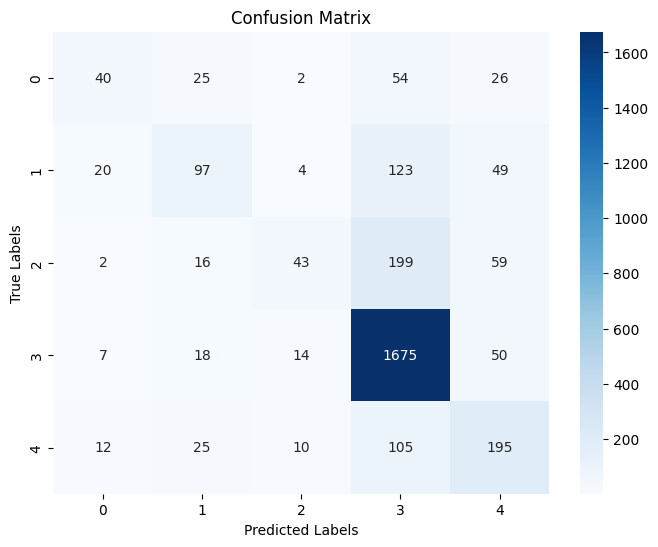

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


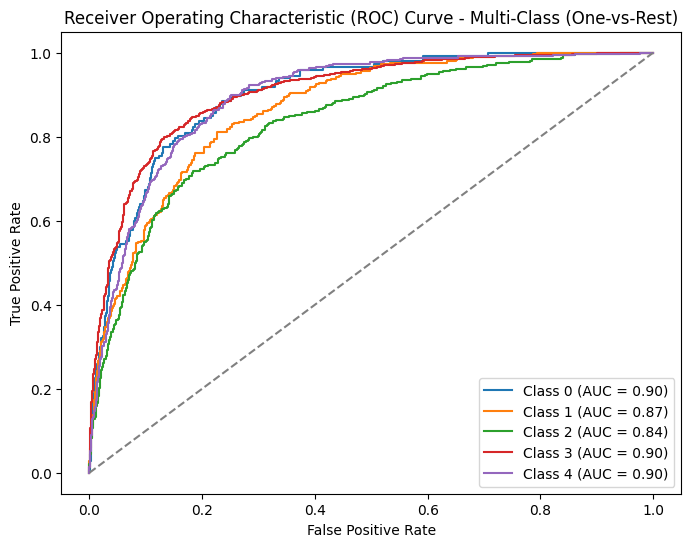

Macro-average AUC: 0.88


In [184]:
pca_unbalanced_results_rf = model_pipeline(_X=pca_X, _y=pca_y, clf_model_name='rf', balanced=False)

Beginning training...
Balanced train-test split: False
Model Algorithm: xgb
X train shape: (11480, 130)
y train shape: (11480,)
X test shape: (2870, 130)
y test shape: (2870,)
100%|██████████| 5/5 [00:25<00:00,  5.12s/trial, best loss: -0.0]
Best Parameters: {'colsample_bytree': 0.5568981335918035, 'gamma': 3.8392819888268797, 'learning_rate': 0.3517717325722587, 'max_depth': 14.0, 'n_estimators': 210.0, 'subsample': 0.9068277038201439}
Final Accuracy: 0.7337979094076655
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.43      0.23      0.30       147
Cassava Brown Streak Disease (CBSD)       0.53      0.37      0.43       293
         Cassava Green Mottle (CGM)       0.52      0.31      0.39       319
       Cassava Mosaic Disease (CMD)       0.82      0.95      0.88      1764
                            Healthy       0.53      0.55      0.54       347

                           accuracy 

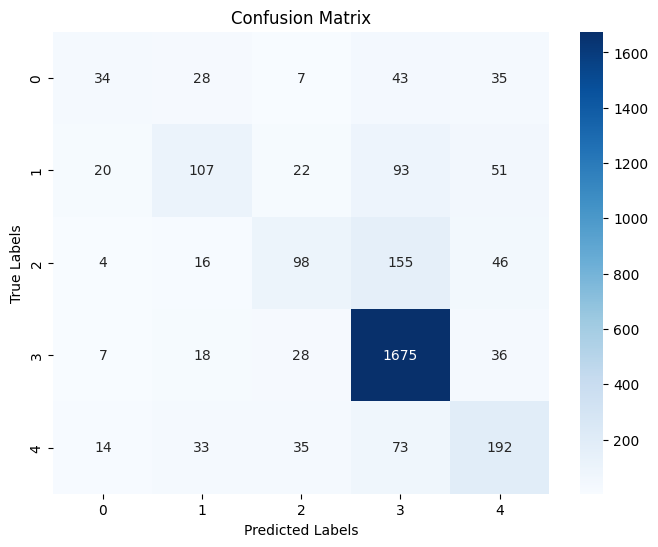

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


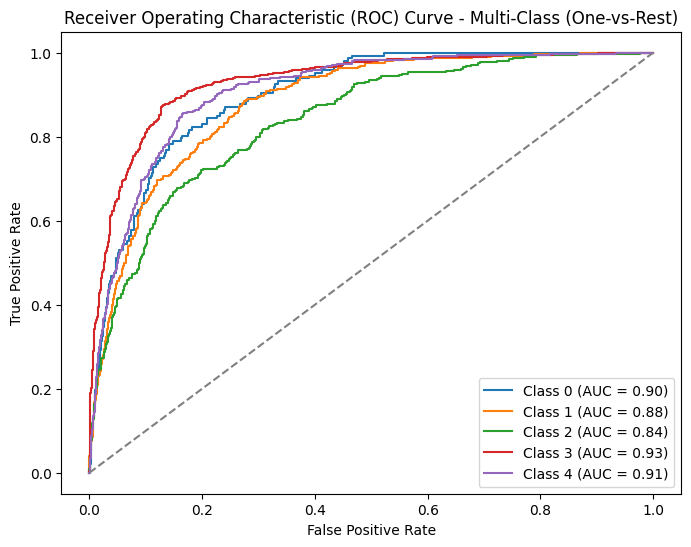

Macro-average AUC: 0.89


In [185]:
pca_unbalanced_results_xgb = model_pipeline(_X=pca_X, _y=pca_y, clf_model_name='xgb', balanced=False)

##### Validate

Validation Accuracy: 0.7148829431438127
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.45      0.28      0.34       184
Cassava Brown Streak Disease (CBSD)       0.46      0.31      0.37       366
         Cassava Green Mottle (CGM)       0.62      0.15      0.24       399
       Cassava Mosaic Disease (CMD)       0.79      0.96      0.87      2206
                            Healthy       0.49      0.50      0.50       433

                           accuracy                           0.71      3588
                          macro avg       0.56      0.44      0.46      3588
                       weighted avg       0.68      0.71      0.68      3588



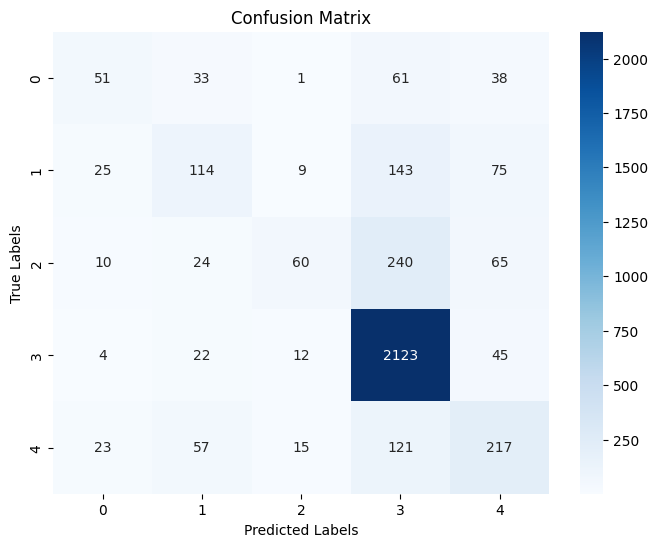

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


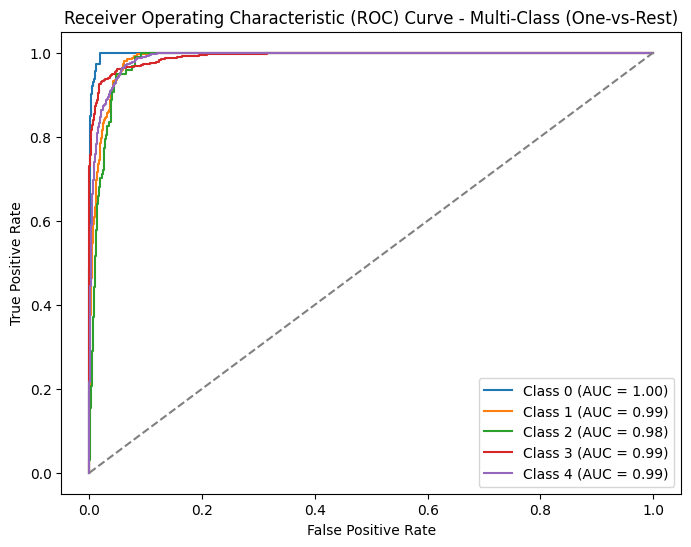

Macro-average AUC: 0.99


In [209]:
pca_unbalanced_rf_validation_metrics = run_validation_metrics(
    _model=pca_unbalanced_results_rf['model'],
    _X_validation=pca_X_validation,
    _y_validation=pca_y_validation)

Validation Accuracy: 0.7385730211817169
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.46      0.24      0.32       184
Cassava Brown Streak Disease (CBSD)       0.47      0.34      0.40       366
         Cassava Green Mottle (CGM)       0.58      0.33      0.42       399
       Cassava Mosaic Disease (CMD)       0.83      0.96      0.89      2206
                            Healthy       0.51      0.52      0.52       433

                           accuracy                           0.74      3588
                          macro avg       0.57      0.48      0.51      3588
                       weighted avg       0.71      0.74      0.71      3588



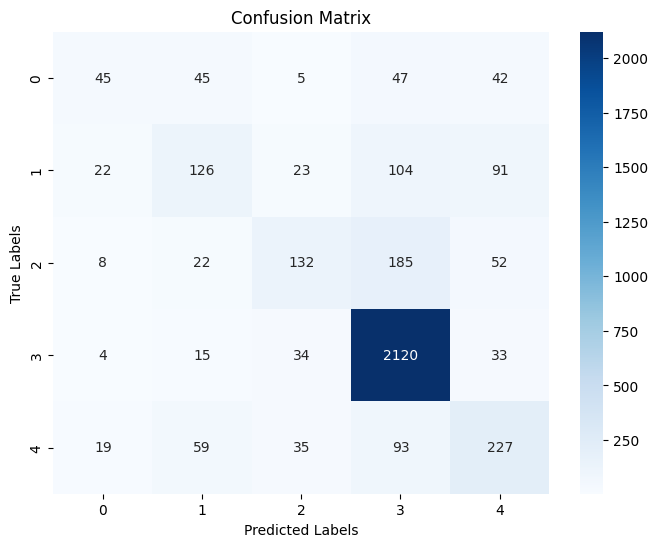

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


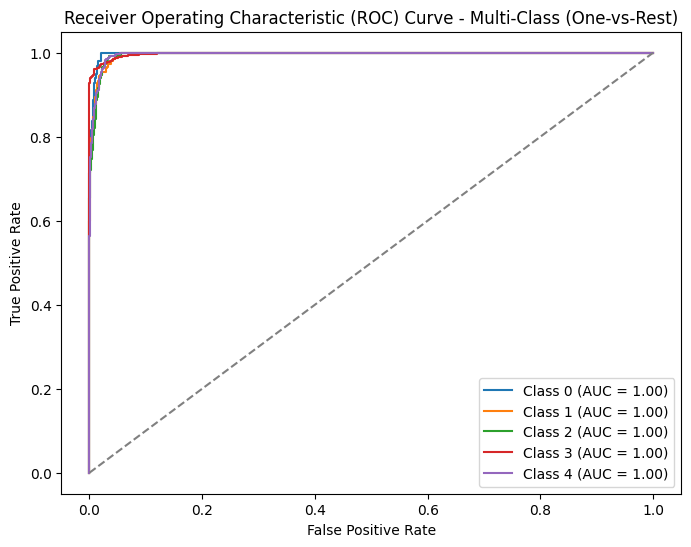

Macro-average AUC: 1.00


In [210]:
pca_unbalanced_xgb_validation_metrics = run_validation_metrics(
    _model=pca_unbalanced_results_xgb['model'],
    _X_validation=pca_X_validation,
    _y_validation=pca_y_validation,
    y_train=pca_unbalanced_results_xgb['y_train'])

#### Comprehensive Report

In [253]:
all_validation_metrics = [
    {'dataset': 'full',
     'balanced': True,
     'model': 'rf',
     'metrics': balanced_rf_validation_metrics},

    {'dataset': 'full',
     'balanced': True,
     'model': 'xgb',
     'metrics': balanced_xgb_validation_metrics},

    {'dataset': 'full',
     'balanced': False,
     'model': 'rf',
     'metrics': unbalanced_rf_validation_metrics},

    {'dataset': 'full',
     'balanced': False,
     'model': 'xgb',
     'metrics': unbalanced_xgb_validation_metrics},

    {'dataset': 'PCA',
     'balanced': True,
     'model': 'rf',
     'metrics': pca_balanced_rf_validation_metrics},

    {'dataset': 'PCA',
     'balanced': True,
     'model': 'xgb',
     'metrics': pca_balanced_xgb_validation_metrics},

    {'dataset': 'PCA',
     'balanced': False,
     'model': 'rf',
     'metrics': pca_unbalanced_rf_validation_metrics},

    {'dataset': 'PCA',
     'balanced': False,
     'model': 'xgb',
     'metrics': pca_unbalanced_xgb_validation_metrics}]

# Flattening the dictionary and converting it into a DataFrame
flattened_data = []

for entry in all_validation_metrics:
    dataset = entry['dataset']
    balanced = entry['balanced']
    model = entry['model']
    accuracy = entry['metrics']['accuracy']
    classifcation_report = entry['metrics']['classifcation_report']

    # Prepare the dictionary for the current row
    row = {
        'dataset': dataset,
        'balanced': balanced,
        'model': model,
        'accuracy': accuracy
    }

    # Add class-specific metrics
    for class_name, metrics in classifcation_report.items():
        if class_name in ['macro avg', 'weighted avg']:
            row[f'{class_name}_precision'] = metrics['precision']
            row[f'{class_name}_recall'] = metrics['recall']
            row[f'{class_name}_f1'] = metrics['f1-score']
            row[f'{class_name}_support'] = metrics['support']


    flattened_data.append(row)

# Creating the DataFrame
all_validation_metrics_df = pd.DataFrame(flattened_data)
all_validation_metrics_df['model_name'] = all_validation_metrics_df['balanced'].apply(lambda x:  'balanced' if x==True else 'unbalanced')
all_validation_metrics_df['model_name'] = all_validation_metrics_df['model_name'] + '-\n' + all_validation_metrics_df['dataset'] + '-\n'
all_validation_metrics_df['model_name'] = all_validation_metrics_df['model_name'] + all_validation_metrics_df['model']
# Display the DataFrame
display(all_validation_metrics_df)

dataset  balanced model  accuracy  macro avg_precision  macro avg_recall  \
0    full      True    rf  0.700669             0.542387          0.621271   
1    full      True   xgb  0.705407             0.551577          0.636580   
2    full     False    rf  0.770067             0.614541          0.614261   
3    full     False   xgb  0.808807             0.677627          0.629521   
4     PCA      True    rf  0.621516             0.462321          0.538340   
5     PCA      True   xgb  0.595596             0.445886          0.517300   
6     PCA     False    rf  0.714883             0.561775          0.440511   
7     PCA     False   xgb  0.738573             0.569865          0.480984   

   macro avg_f1  macro avg_support  weighted avg_precision  \
0      0.560545             3588.0                0.762865   
1      0.576396             3588.0                0.770416   
2      0.611944             3588.0                0.773222   
3      0.649820             3588.0                0.798903   
4      0.477236             3588.0                0.710269   
5      0.461540             3588.0                0.704436   
6      0.464046             3588.0                0.683558   
7      0.509283             3588.0                0.708697   

   weighted avg_recall  weighted avg_f1  weighted avg_support  \
0             0.700669         0.721095                3588.0   
1             0.705407         0.726798                3588.0   
2             0.770067         0.770457                3588.0   
3             0.808807         0.801140                3588.0   
4             0.621516         0.650423                3588.0   
5             0.595596         0.630864                3588.0   
6             0.714883         0.675686                3588.0   
7             0.738573         0.714363                3588.0   

                model_name  
0     balanced-\nfull-\nrf  
1    balanced-\nfull-\nxgb  
2   unbalanced-\nfull-\nrf  
3  unbalanced-\nfull-\nxgb  
4      balanced-\nPCA-\nrf  
5     balanced-\nPCA-\nxgb  
6    unbalanced-\nPCA-\nrf  
7   unbalanced-\nPCA-\nxgb

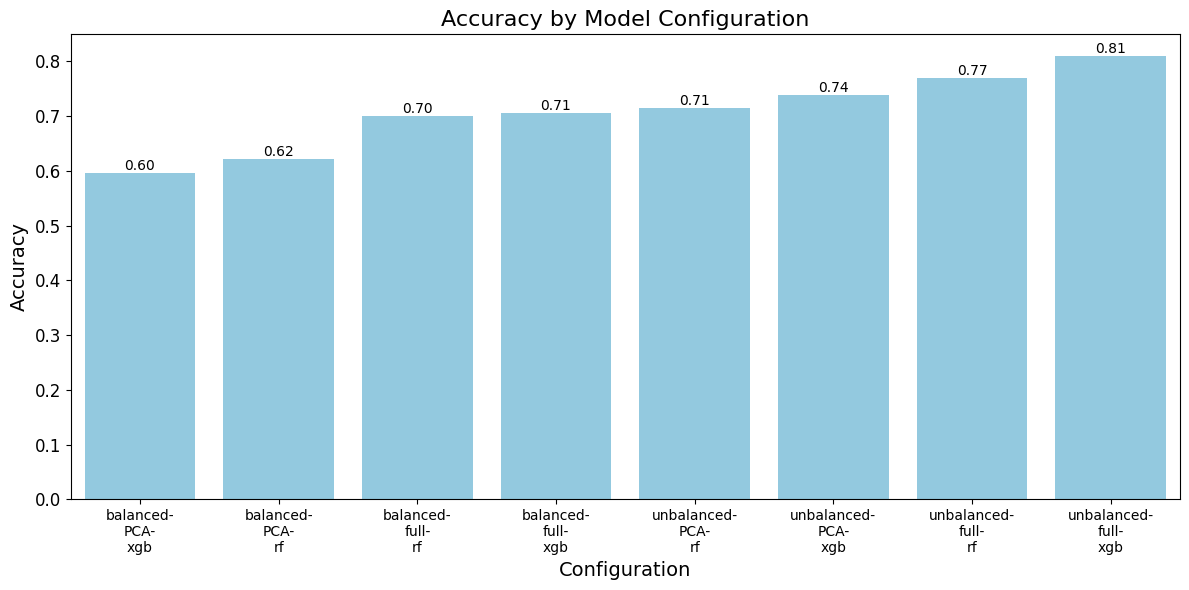

In [257]:
# Create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=all_validation_metrics_df.sort_values(by='accuracy'),
                 x='model_name',
                 y='accuracy', color='skyblue')

# Add labels and title
plt.title('Accuracy by Model Configuration', fontsize=16)
plt.xlabel('Configuration', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=10)
plt.xticks(rotation=0)
plt.yticks(fontsize=12)

# Add the actual value on top of each bar
for bar in ax.patches:
    bar_height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate
        bar_height,  # y-coordinate
        f'{bar_height:.2f}',  # Format the text to 2 decimal places
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10,  # Font size
        color='black'  # Text color
    )

# Show the plot
plt.tight_layout()
plt.show()


### Model Evaluation

#### Pre-defined functions

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


def plot_pca_2d(X, y):

  # Assuming X is your feature matrix and y is your target labels (e.g., string labels)

  # Encode class labels as numbers
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Perform PCA
  pca = PCA(n_components=2)  # Reduce to 2 components for 2D visualization
  reduced_features = pca.fit_transform(X)

  # Plot the PCA results
  plt.figure(figsize=(8, 6))

  # Scatter plot with coloring based on encoded class labels
  scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y_encoded, cmap="viridis", alpha=0.8)

  # Add colorbar to indicate the class labels
  plt.colorbar(scatter, label="Class")

  # Add titles and labels
  plt.title("PCA Visualization of Feature Space")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")

  # Display grid
  plt.grid(True)

  # Show the plot
  plt.show()

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

def plot_tsne_2d(X, y):
  # Assuming X is your feature matrix and y is your target labels (e.g., string labels)

  # Encode class labels as numbers
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Perform t-SNE
  tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2 components for 2D visualization
  reduced_features_tsne = tsne.fit_transform(X)

  # Plot the t-SNE results
  plt.figure(figsize=(8, 6))

  # Scatter plot with coloring based on encoded class labels
  scatter_tsne = plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c=y_encoded, cmap="viridis", alpha=0.8)

  # Add colorbar to indicate the class labels
  plt.colorbar(scatter_tsne, label="Class")

  # Add titles and labels
  plt.title("t-SNE Visualization of Feature Space")
  plt.xlabel("t-SNE Component 1")
  plt.ylabel("t-SNE Component 2")

  # Display grid
  plt.grid(True)

  # Show the plot
  plt.show()

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

def plot_pca_3d(X, y):
  # Assuming X is your feature matrix and y is your target labels (e.g., string labels)

  # Encode class labels as numbers
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Perform PCA (3 components for 3D)
  pca = PCA(n_components=3)
  reduced_features_pca = pca.fit_transform(X)

  # Plot the 3D PCA results
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot with coloring based on encoded class labels
  scatter_pca = ax.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], reduced_features_pca[:, 2],
                          c=y_encoded, cmap="viridis", alpha=0.8)

  # Add colorbar to indicate the class labels
  fig.colorbar(scatter_pca, ax=ax, label="Class")

  # Add titles and labels
  ax.set_title("3D PCA Visualization of Feature Space")
  ax.set_xlabel("PCA Component 1")
  ax.set_ylabel("PCA Component 2")
  ax.set_zlabel("PCA Component 3")

  # Show the plot
  plt.show()

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

def plot_tsne_3d(X, y):

  # Assuming X is your feature matrix and y is your target labels (e.g., string labels)

  # Encode class labels as numbers
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Perform t-SNE (3 components for 3D)
  tsne = TSNE(n_components=3, random_state=42)
  reduced_features_tsne = tsne.fit_transform(X)

  # Plot the 3D t-SNE results
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot with coloring based on encoded class labels
  scatter_tsne = ax.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], reduced_features_tsne[:, 2],
                            c=y_encoded, cmap="viridis", alpha=0.8)

  # Add colorbar to indicate the class labels
  fig.colorbar(scatter_tsne, ax=ax, label="Class")

  # Add titles and labels
  ax.set_title("3D t-SNE Visualization of Feature Space")
  ax.set_xlabel("t-SNE Component 1")
  ax.set_ylabel("t-SNE Component 2")
  ax.set_zlabel("t-SNE Component 3")

  # Show the plot
  plt.show()

#### Balanced Model

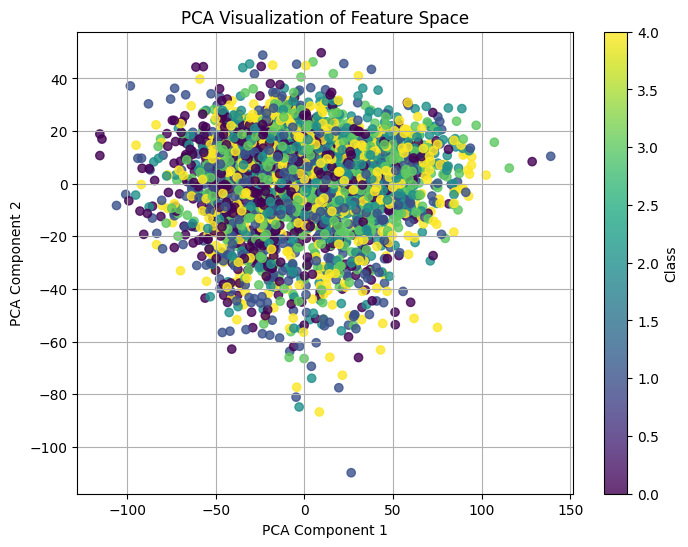

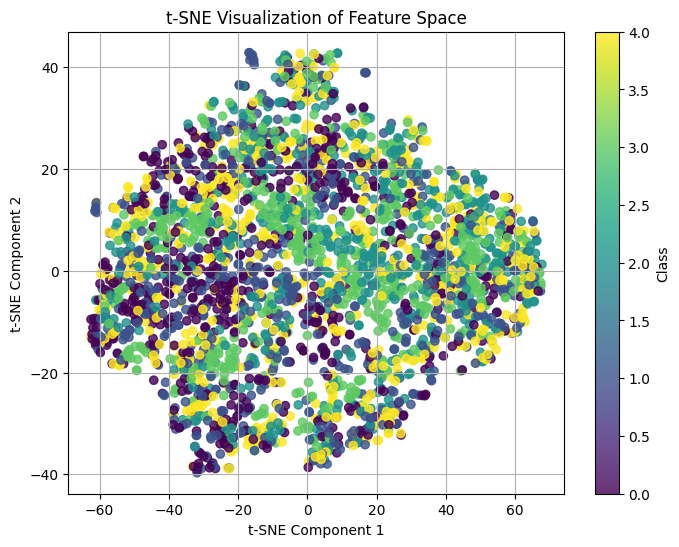

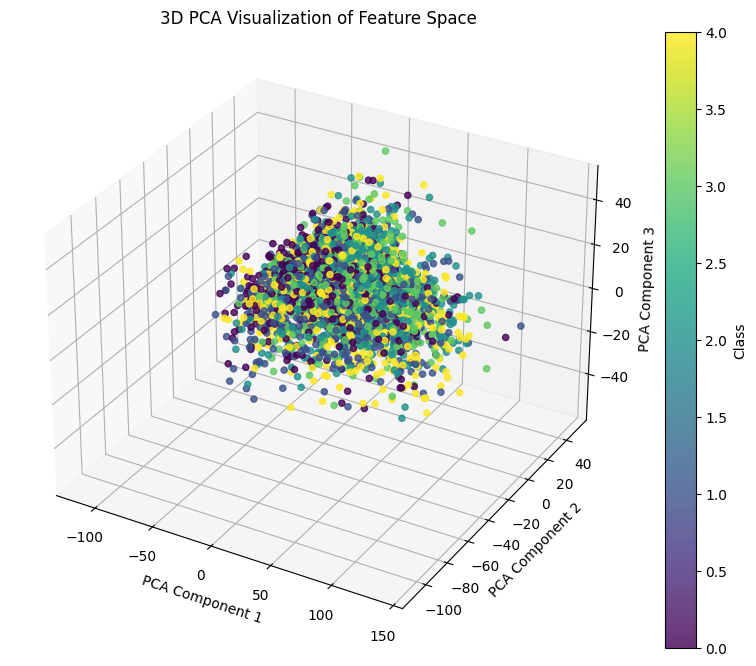

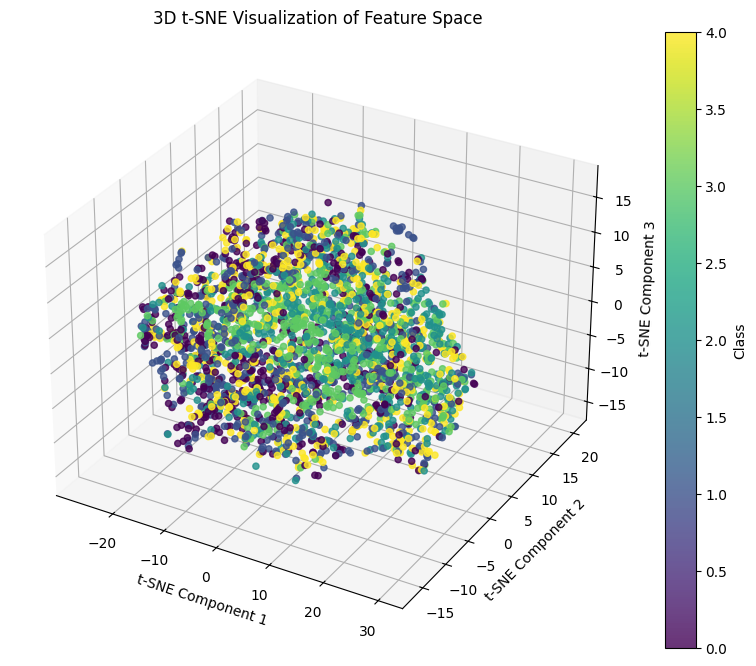

In [225]:
# Balanced plotting
plot_pca_2d(X=balanced_results_rf['X_train'],
            y=balanced_results_rf['y_train'])
plot_tsne_2d(X=balanced_results_rf['X_train'],
            y=balanced_results_rf['y_train'])
plot_pca_3d(X=balanced_results_rf['X_train'],
            y=balanced_results_rf['y_train'])
plot_tsne_3d(X=balanced_results_rf['X_train'],
            y=balanced_results_rf['y_train'])

#### Unbalanced Model

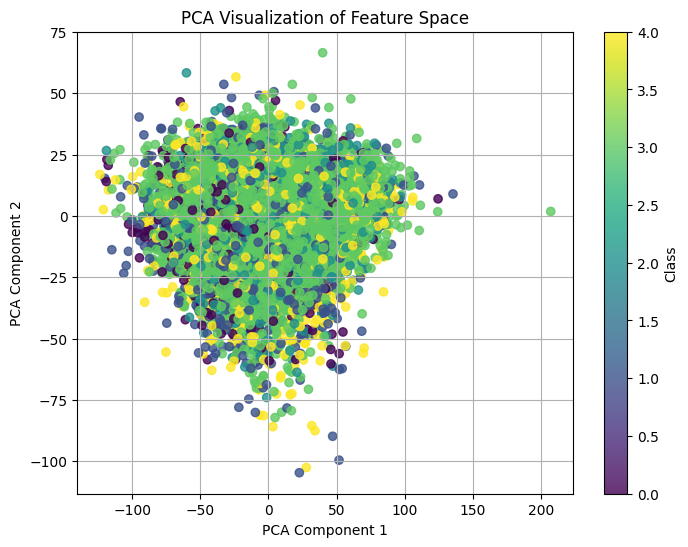

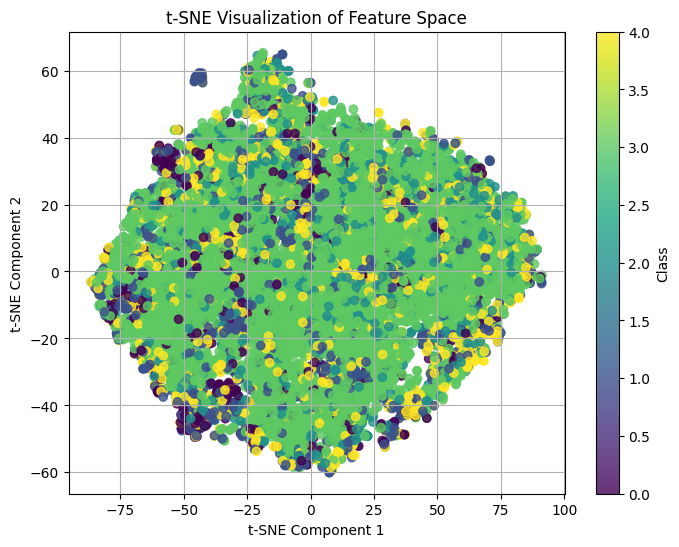

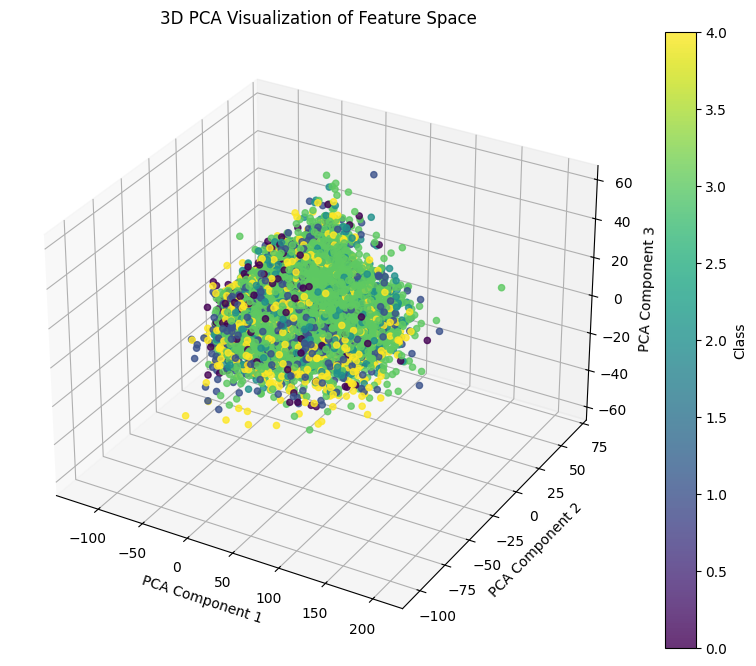

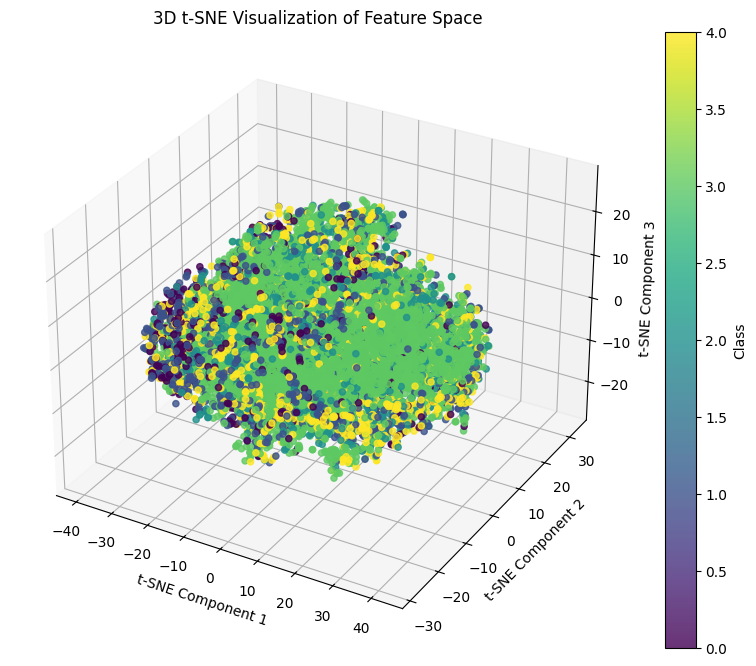

In [273]:
# Unbalanced plotting
plot_pca_2d(X=unbalanced_results_rf['X_train'],
            y=unbalanced_results_rf['y_train'])
plot_tsne_2d(X=unbalanced_results_rf['X_train'],
             y=unbalanced_results_rf['y_train'])
plot_pca_3d(X=unbalanced_results_rf['X_train'],
             y=unbalanced_results_rf['y_train'])
plot_tsne_3d(X=unbalanced_results_rf['X_train'],
             y=unbalanced_results_rf['y_train'])

#### Balanced PCA Model

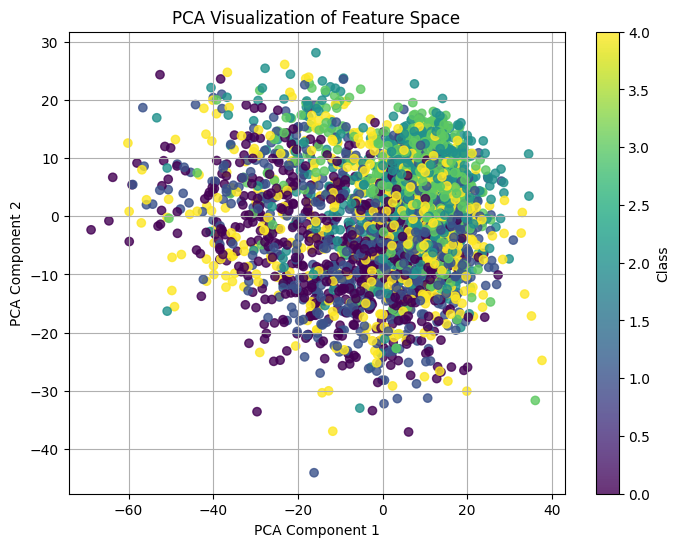

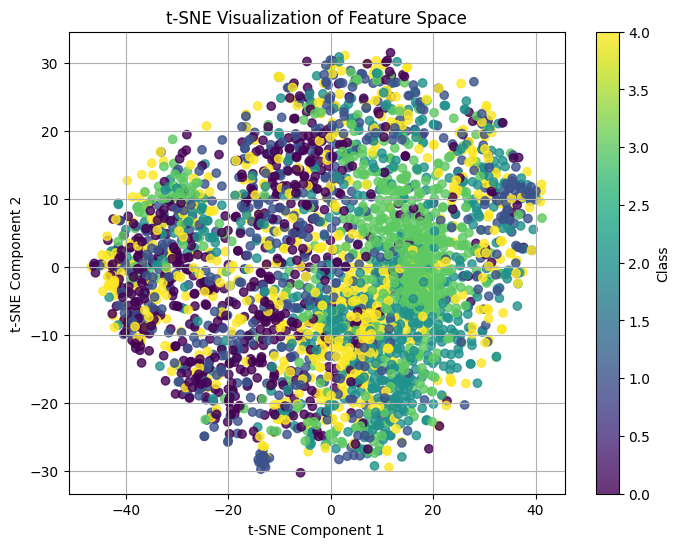

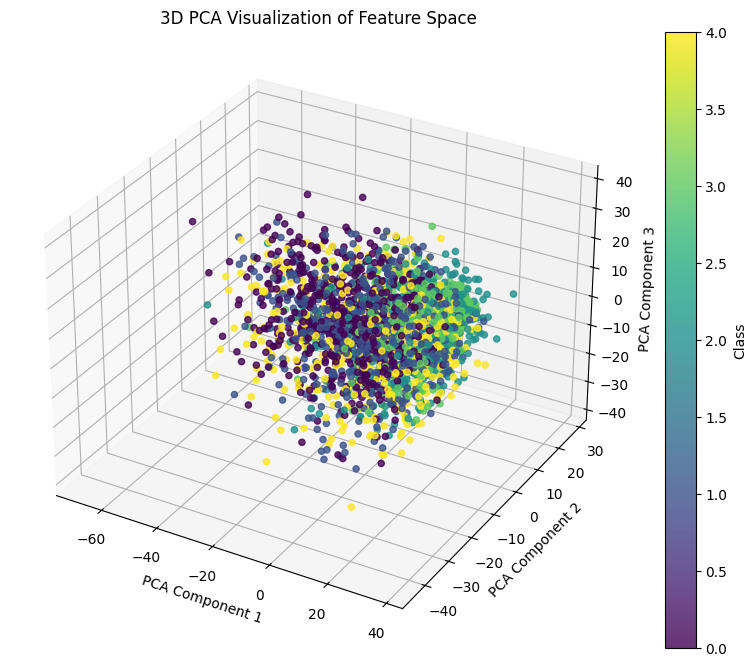

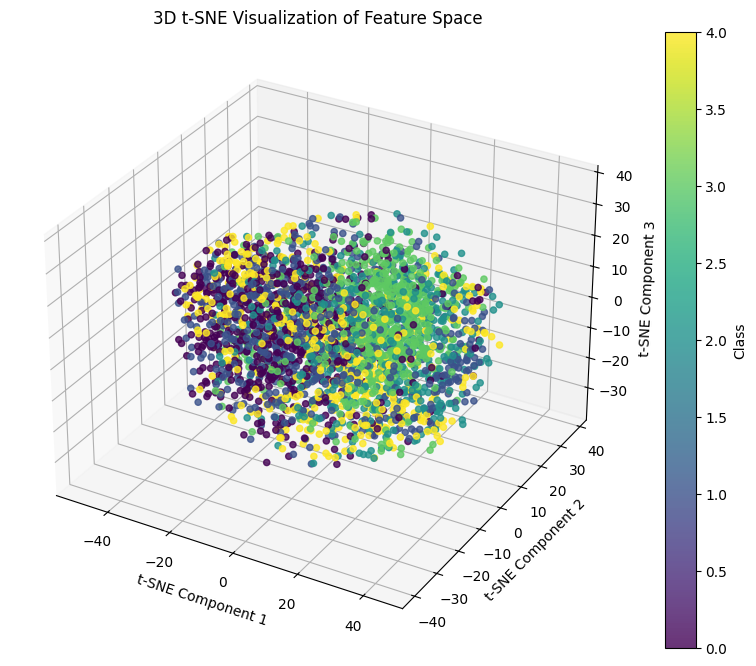

In [274]:
# balanced PCA plotting
plot_pca_2d(X=pca_balanced_results_rf['X_train'],
            y=pca_balanced_results_rf['y_train'])
plot_tsne_2d(X=pca_balanced_results_rf['X_train'],
            y=pca_balanced_results_rf['y_train'])
plot_pca_3d(X=pca_balanced_results_rf['X_train'],
            y=pca_balanced_results_rf['y_train'])
plot_tsne_3d(X=pca_balanced_results_rf['X_train'],
            y=pca_balanced_results_rf['y_train'])

#### Unbalanced PCA Model

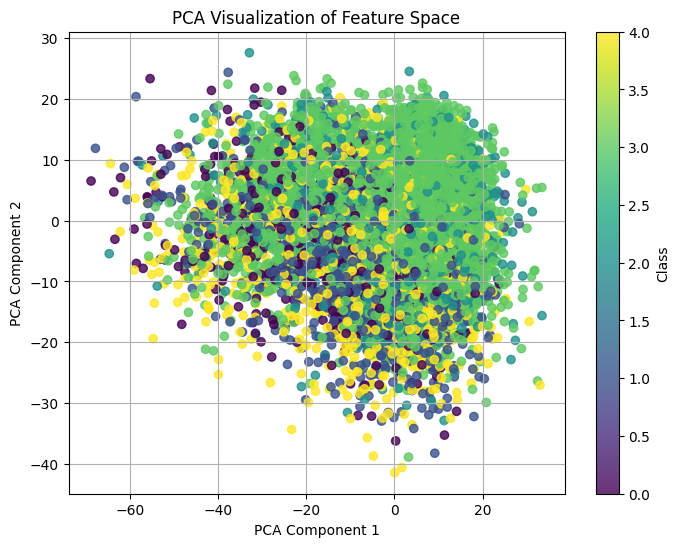

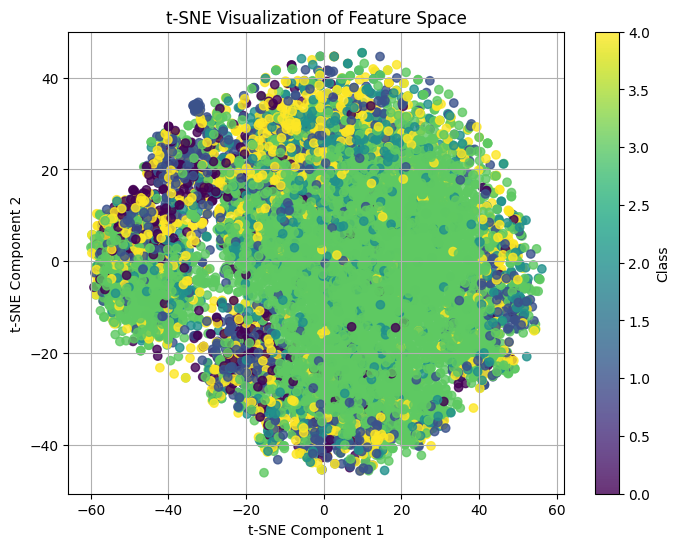

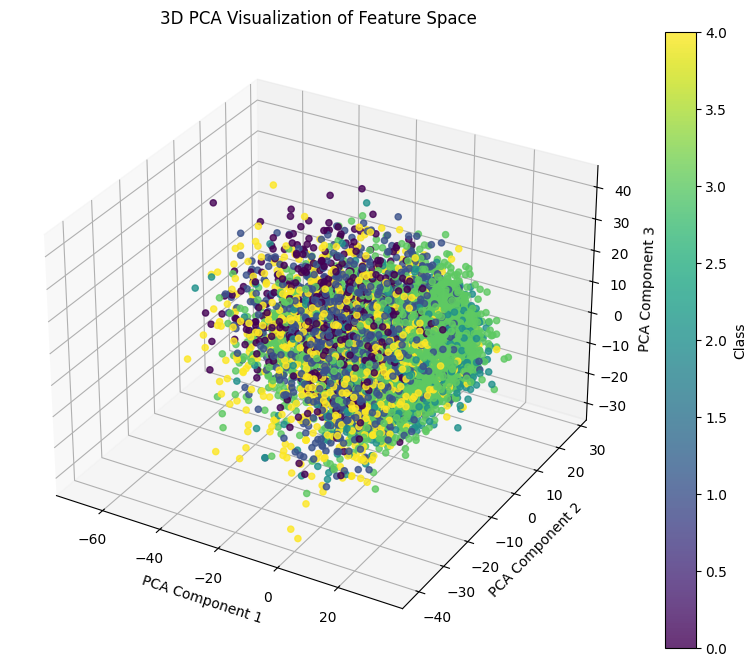

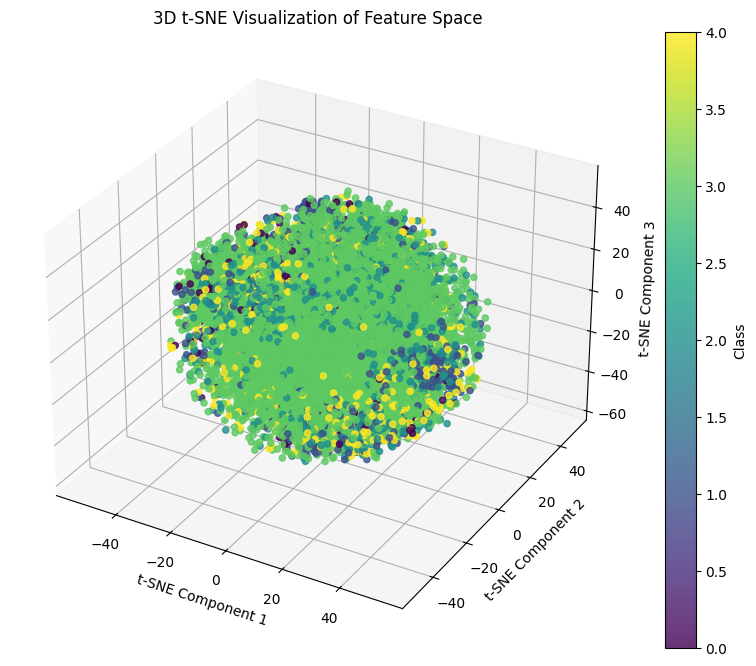

In [275]:
# unbalanced PCA plotting
plot_pca_2d(X=pca_unbalanced_results_rf['X_train'],
            y=pca_unbalanced_results_rf['y_train'])
plot_tsne_2d(X=pca_unbalanced_results_rf['X_train'],
            y=pca_unbalanced_results_rf['y_train'])
plot_pca_3d(X=pca_unbalanced_results_rf['X_train'],
            y=pca_unbalanced_results_rf['y_train'])
plot_tsne_3d(X=pca_unbalanced_results_rf['X_train'],
            y=pca_unbalanced_results_rf['y_train'])